# TP1 - 22.45 Redes Neuronales - Regresión Logística y Lineal

## Regresión Logística

### Import required libraries and dataset

In [182]:
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
import datetime
from os.path import exists
tf.config.set_visible_devices([], 'GPU')

In [183]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [184]:
from numpy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import tensorflow_addons as tfa
from tensorboard.plugins.hparams import api as hp

In [185]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Download and load Fashion MNIST dataset

In [186]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

### Normalize the dataset

In [187]:
data_max = np.max(train_X)
train_X = train_X.astype('float32') / data_max
test_X = test_X.astype('float32') / data_max
np.max(train_X)

1.0

### Exploratory Data Analysis

#### Example: Show the first object of the train dataset

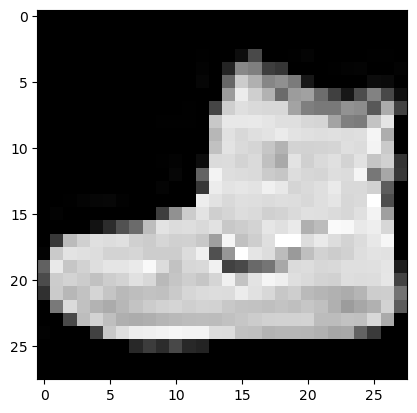

In [188]:
plt.imshow(train_X[0,...], cmap="gray")

#### Show a few instances of each class

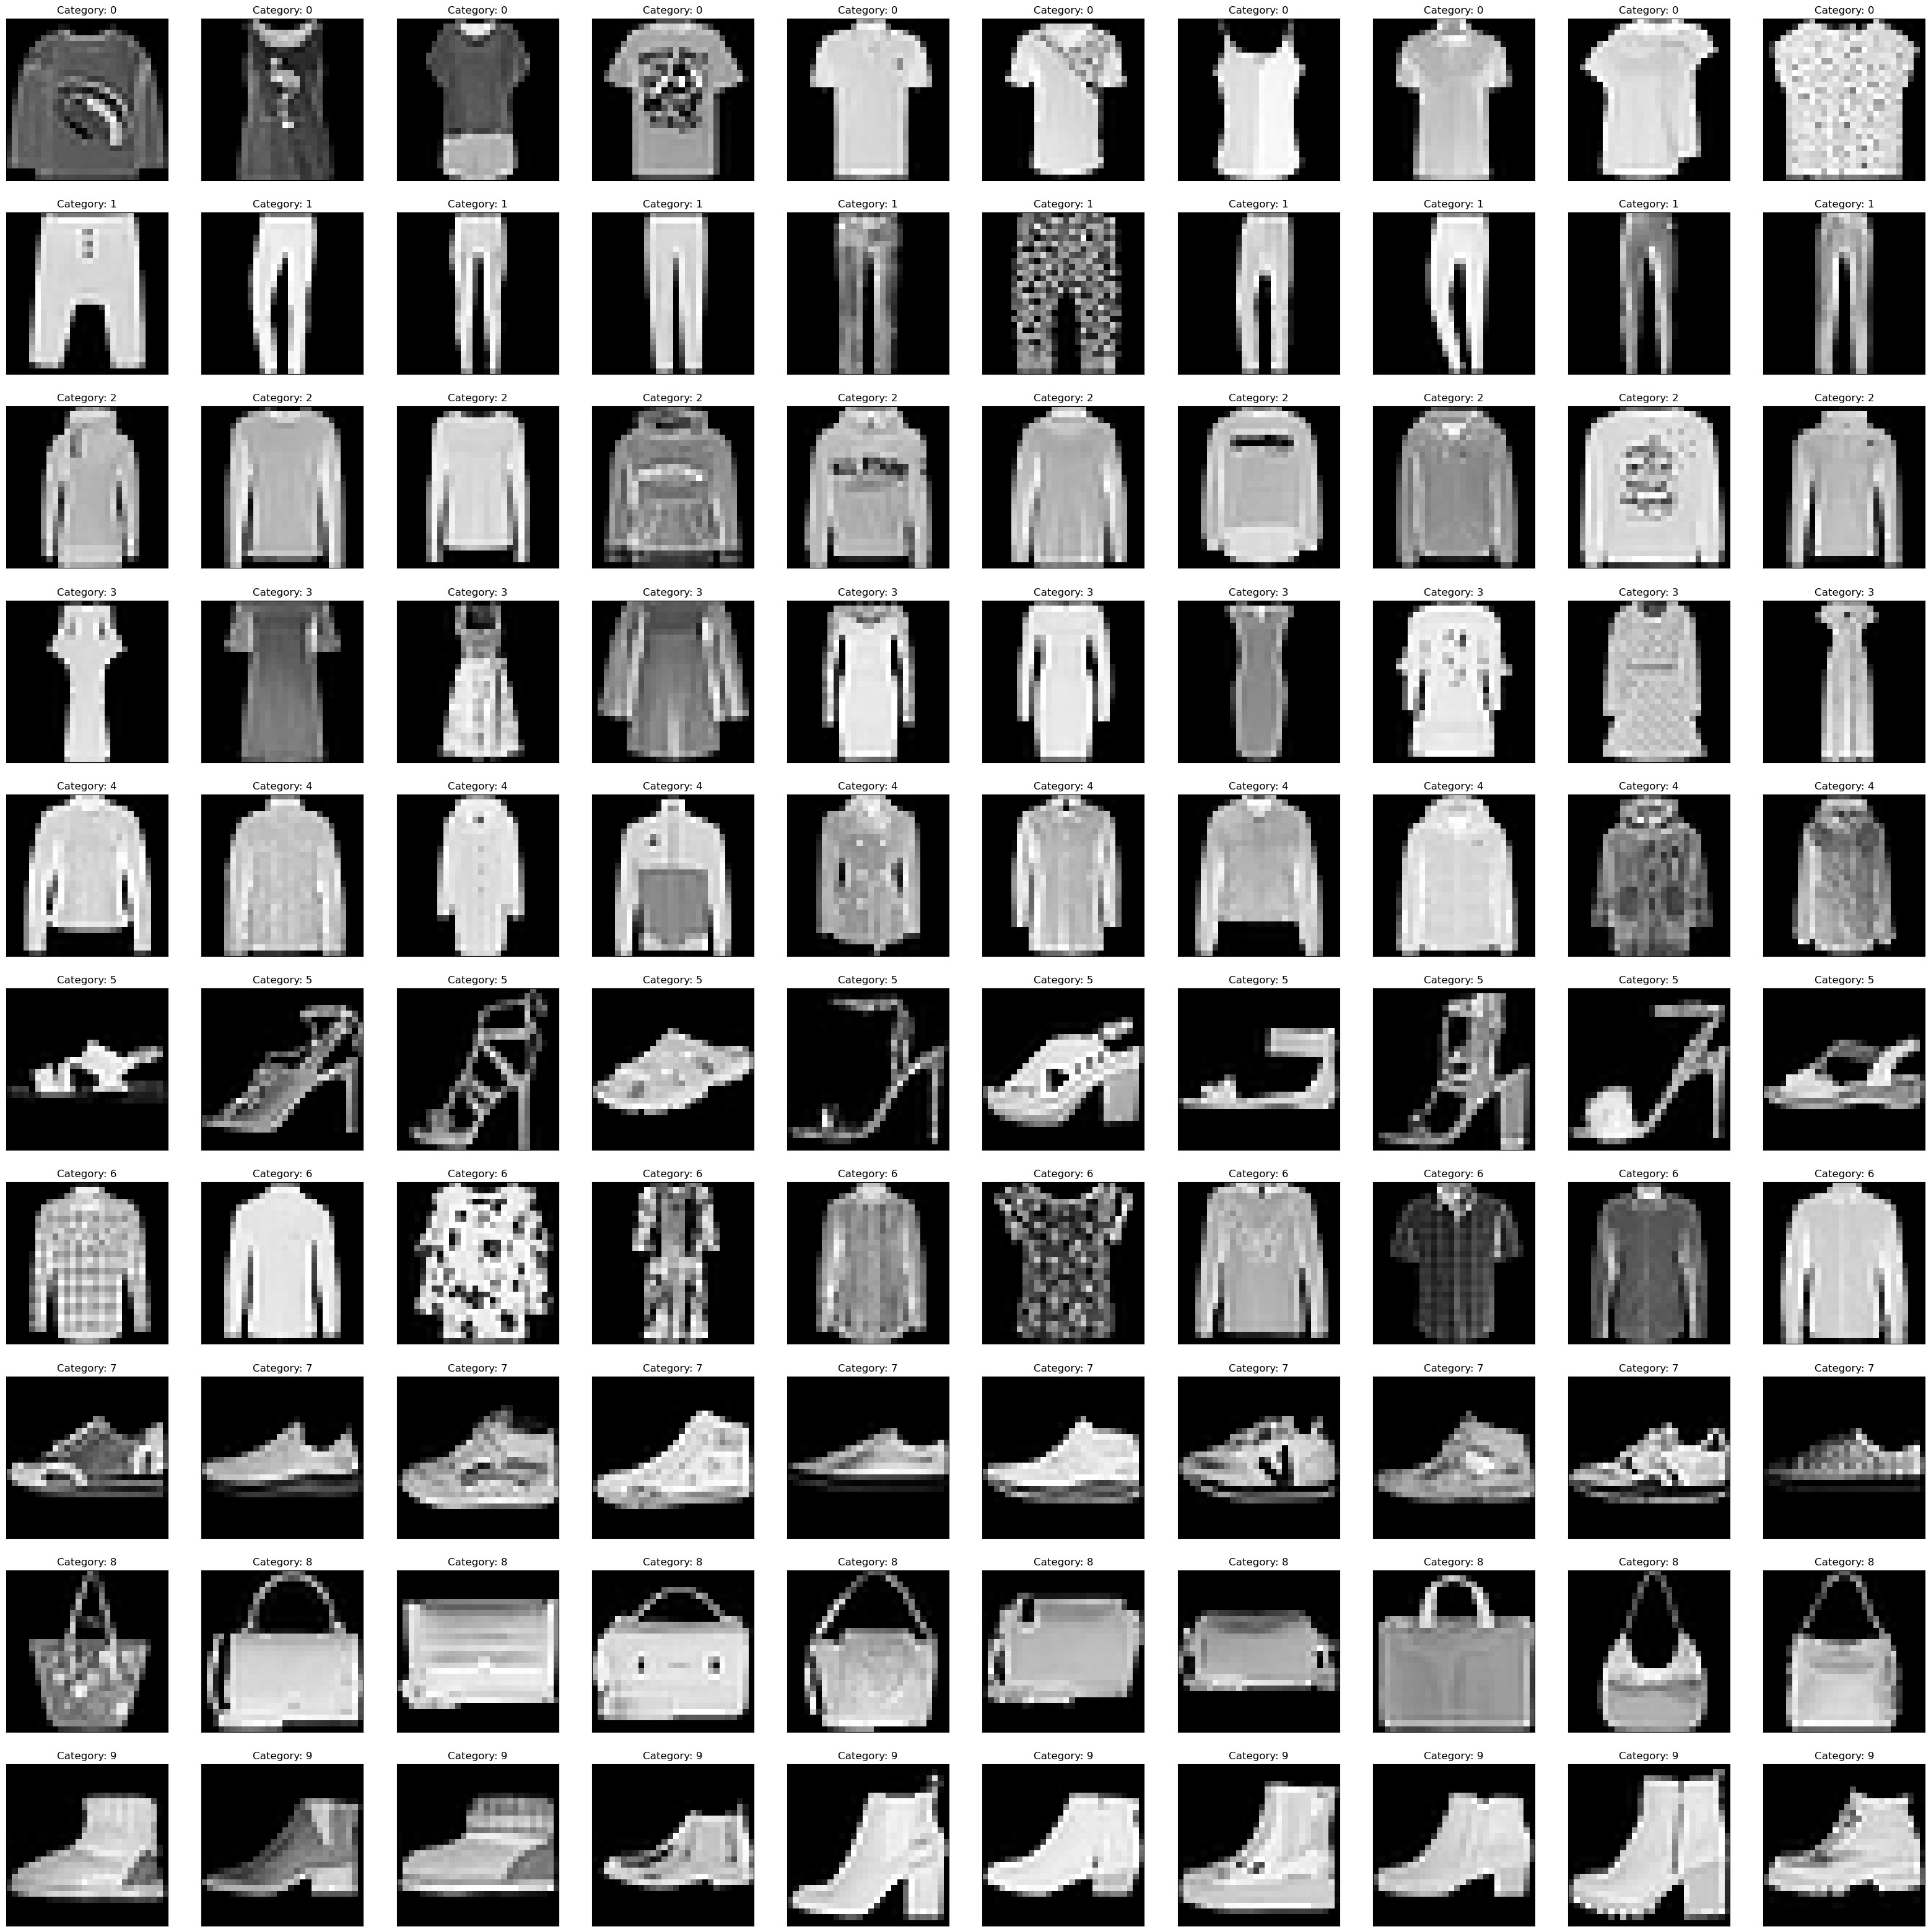

In [189]:
fig = plt.figure(figsize=(40, 40))  # width, height in inches

# idx works on np.array and not lists.
idx = np.argsort(train_y)

train_X_sorted = np.array(train_X)[idx]
train_y_sorted = np.array(train_y)[idx]

count = 0

for i in range(100):
    count = int(np.floor(i / 10))
    sub = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    sub.imshow(train_X_sorted[i + count * 6000,:,:], interpolation='nearest', cmap='gray')
    sub.set_title('Category: ' + str(train_y_sorted[i + count * 6000]))

#### Look at the data distribution

##### Training data

{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


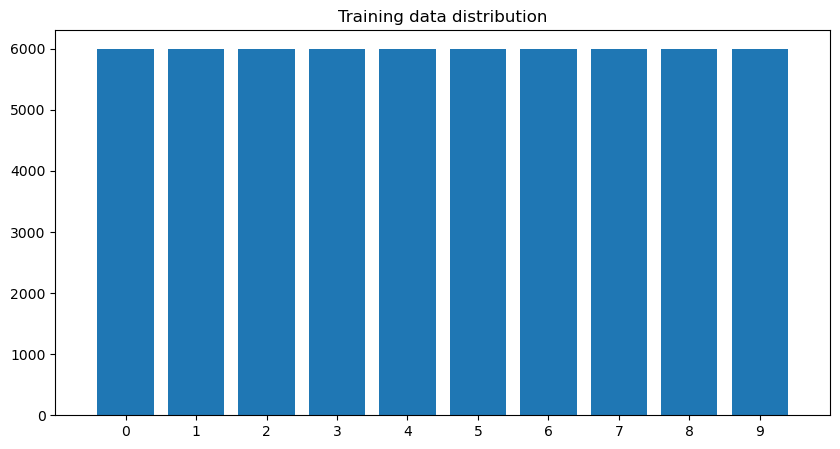

In [190]:
unique, counts = np.unique(train_y, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(train_y)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Training data distribution')

plt.show()

##### Testing data

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


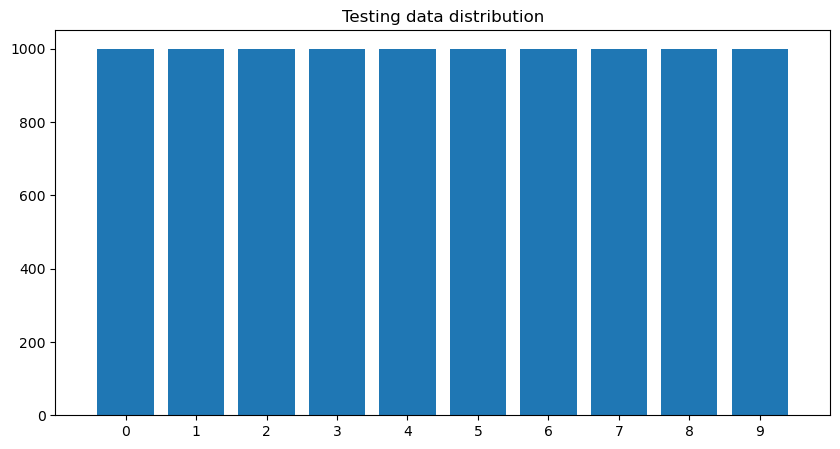

In [191]:
unique, counts = np.unique(test_y, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(test_y)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Testing data distribution')

plt.show()

### Convert the dataset from a vector form to a categorical distribution

In [192]:
num_classes = np.max(train_y) + 1
train_y_cat = utils.to_categorical(train_y, num_classes)
test_y_cat = utils.to_categorical(test_y, num_classes)

### Softmax

#### Define useful callbacks

In [193]:
# Callback to stop training if, after 5 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [194]:
# Callback to save the weights of the best model
checkpoint_filepath_softmax = './checkpoints/softmax/'
model_checkpoint_callback_softmax = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_softmax,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [195]:
# Callback to save logs and metrics for TensorBoard
log_dir_softmax = "logs/fit/softmax/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_softmax = tf.keras.callbacks.TensorBoard(log_dir=log_dir_softmax)

In [196]:
callbacks = [early_stop_callback, tensorboard_callback_softmax, model_checkpoint_callback_softmax]

#### Define and compile the model

In [197]:
softmax_model = Sequential()
softmax_model.add(layers.Flatten(input_shape=(28,28)))
softmax_model.add(layers.Dense(num_classes, activation="softmax", kernel_initializer=tf.keras.initializers.GlorotNormal()))
softmax_model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_35 (Flatten)        (None, 784)               0         
                                                                 
 dense_136 (Dense)           (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [198]:
optimizer = optimizers.Adam(learning_rate=0.00093, beta_1=0.95, beta_2=0.94)
metrics = ["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
softmax_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics=metrics)

#### Fit the model to the train data and validate it with the test data

In [199]:
# We load the previously best weights to save time on training
# if (exists(checkpoint_filepath_softmax)):
#    softmax_model.load_weights(checkpoint_filepath_softmax)

In [200]:
softmax_history = softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 32, epochs=100, callbacks=callbacks)

Epoch 1/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5860 - accuracy: 0.8009 - f1_score: 0.7976 - f1_score_micro: 0.8009 - precision: 0.8693 - recall: 0.7175 - val_loss: 0.5099 - val_accuracy: 0.8250 - val_f1_score: 0.8248 - val_f1_score_micro: 0.8250 - val_precision: 0.8684 - val_recall: 0.7757
Epoch 2/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4602 - accuracy: 0.8448 - f1_score: 0.8435 - f1_score_micro: 0.8448 - precision: 0.8816 - recall: 0.8032 - val_loss: 0.4832 - val_accuracy: 0.8366 - val_f1_score: 0.8353 - val_f1_score_micro: 0.8366 - val_precision: 0.8720 - val_recall: 0.7997
Epoch 3/100
1875/1875 [==============================] - 2s 997us/step - loss: 0.4371 - accuracy: 0.8527 - f1_score: 0.8516 - f1_score_micro: 0.8527 - precision: 0.8850 - recall: 0.8162 - val_loss: 0.4837 - val_accuracy: 0.8341 - val_f1_score: 0.8321 - val_f1_score_micro: 0.8341 - val_precision: 0.8729 - val_recall: 0.8011
Epoch 4/100
1875/1875 [======

#### Plot important metrics

##### TensorBoard session

In [201]:
%tensorboard --logdir $log_dir_softmax

##### Loss

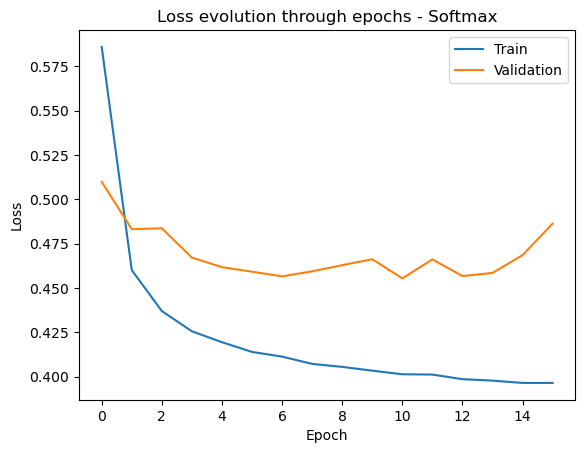

In [202]:
plt.plot(softmax_history.history["loss"], label="Train")
plt.plot(softmax_history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution through epochs - Softmax')
plt.show()

##### Accuracy

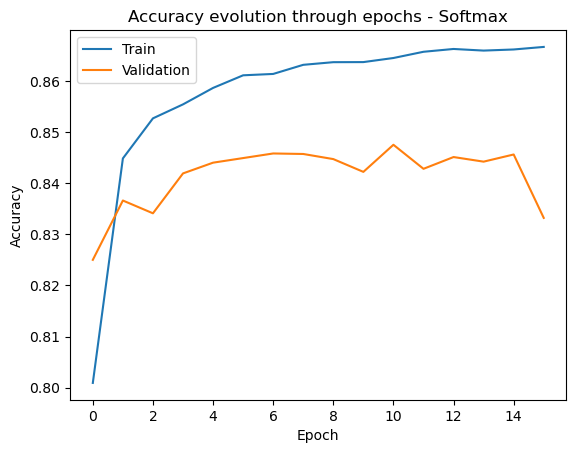

In [203]:
plt.plot(softmax_history.history["accuracy"], label="Train")
plt.plot(softmax_history.history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy evolution through epochs - Softmax')
plt.show()

##### Precision

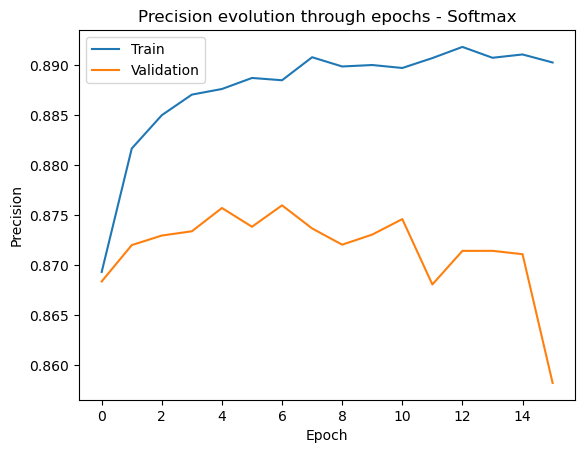

In [204]:
plt.plot(softmax_history.history["precision"], label="Train")
plt.plot(softmax_history.history["val_precision"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision evolution through epochs - Softmax')
plt.show()

##### Recall

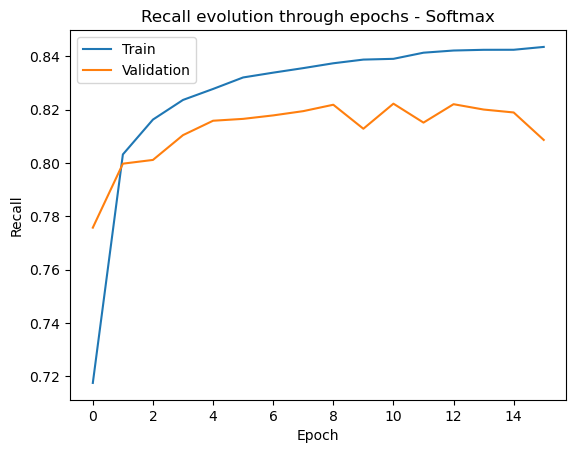

In [205]:
plt.plot(softmax_history.history["recall"], label="Train")
plt.plot(softmax_history.history["val_recall"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall evolution through epochs - Softmax')
plt.show()

##### F1-Score

###### Macro

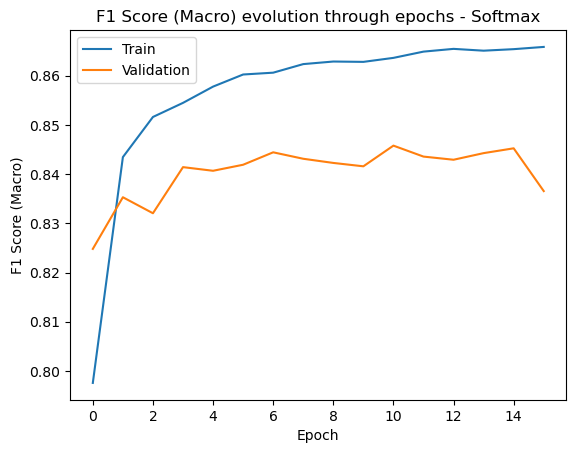

In [206]:
plt.plot(softmax_history.history["f1_score"], label="Train")
plt.plot(softmax_history.history["val_f1_score"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score (Macro) evolution through epochs - Softmax')
plt.show()

###### Micro

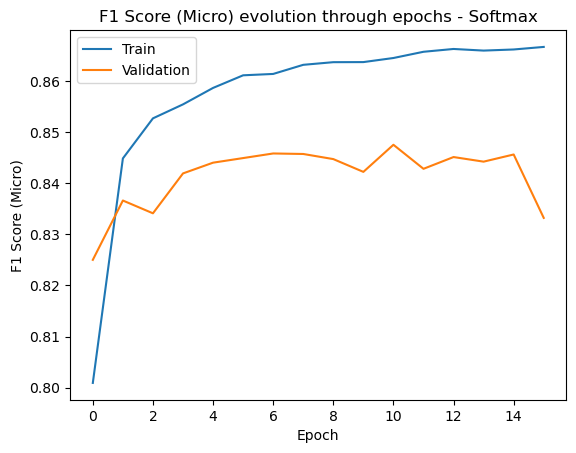

In [207]:
plt.plot(softmax_history.history["f1_score_micro"], label="Train")
plt.plot(softmax_history.history["val_f1_score_micro"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Micro)')
plt.title('F1 Score (Micro) evolution through epochs - Softmax')
plt.show()

En este problema los F1 Score tanto macro como micro son muy similares a causa de que no existe desbalance de clases.

##### ROC and AUC

313/313 [==============================] - 0s 570us/step


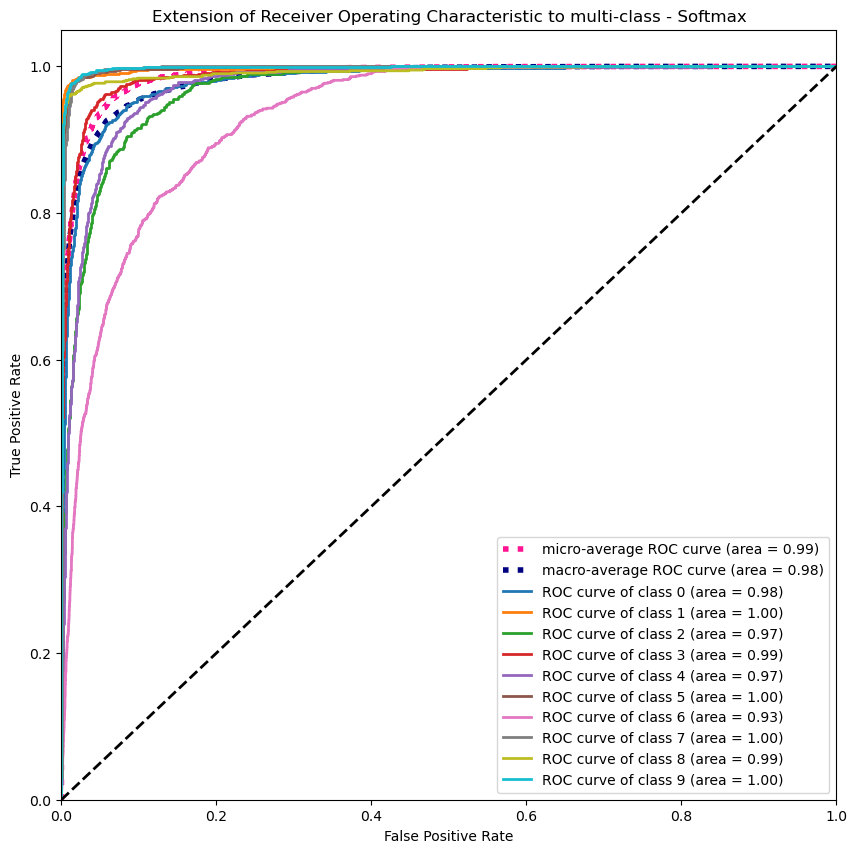

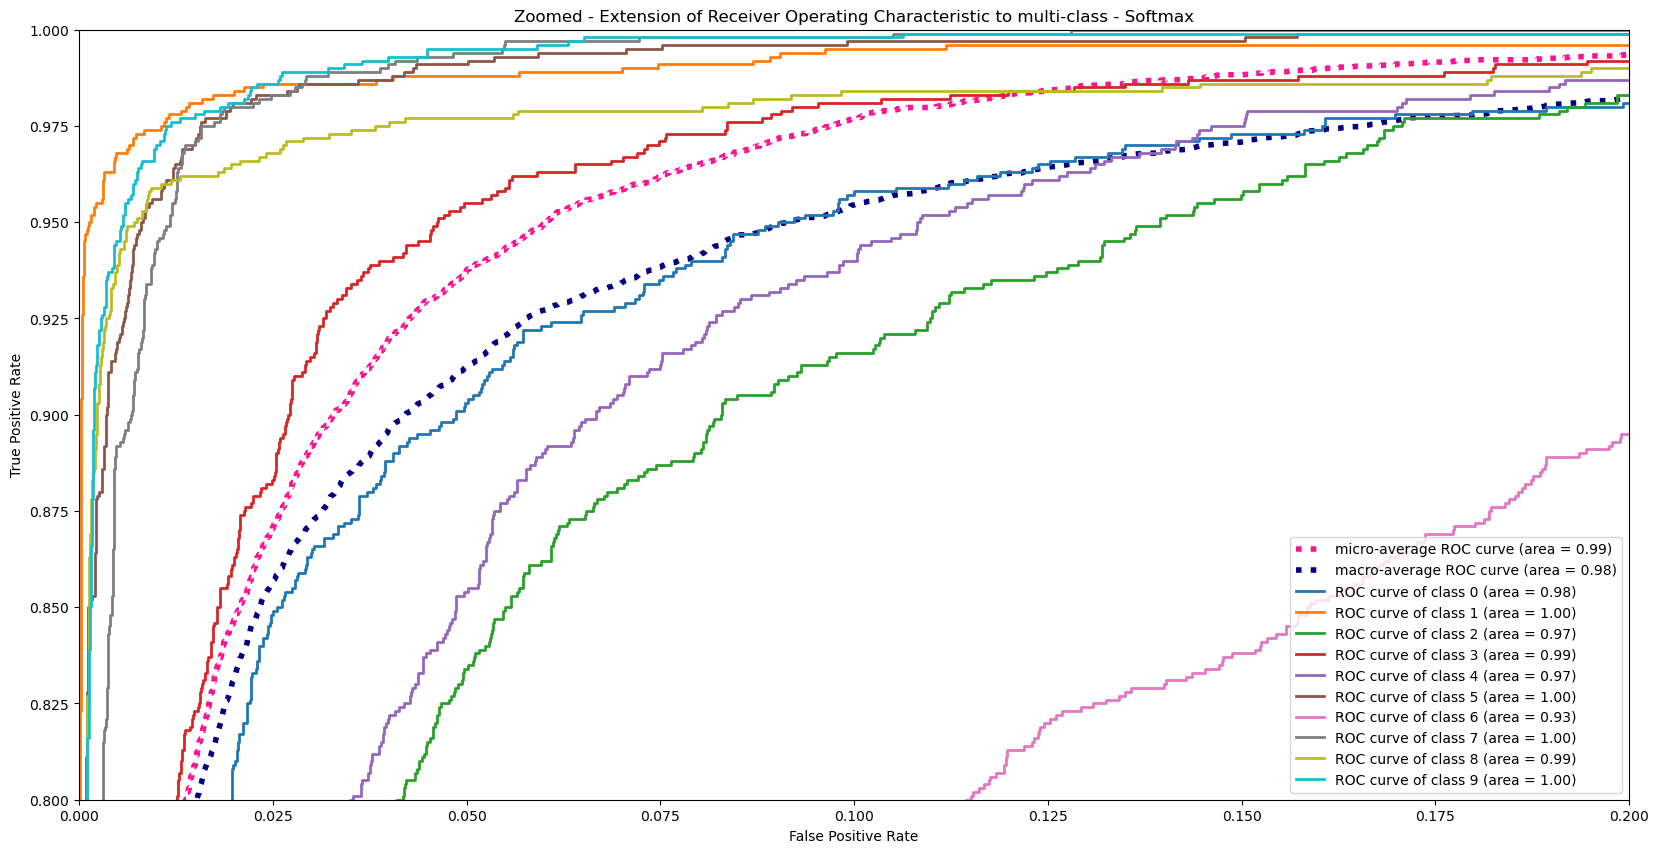

In [208]:
# Plot linewidth.
lw = 2

# Get score
y_score = softmax_model.predict(test_X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y_cat.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(20,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed - Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()

Al igual que para el F1 Score, las curvas ROC tanto macro como micro dan muy similares porque no hay desbalance de clases.

### MLP

#### Define useful callbacks

In [209]:
# Callback to stop training if, after 10 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [210]:
# Callback to save the weights of the best model
checkpoint_filepath_mlp = './checkpoints/mlp/'
model_checkpoint_callback_mlp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_mlp,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [211]:
# Callback to save logs and metrics for TensorBoard
log_dir_mlp = "logs/fit/mlp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_mlp = tf.keras.callbacks.TensorBoard(log_dir=log_dir_mlp)

In [212]:
# Callback to reduce LR if we find a plateau in validation accuracy
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.00005)

In [213]:
callbacks = [early_stop_callback, tensorboard_callback_mlp, model_checkpoint_callback_mlp, reduce_lr]

#### Define and compile the model

In [214]:
mlp_model = Sequential()
mlp_model.add(layers.Flatten(input_shape=(28,28)))
mlp_model.add(layers.BatchNormalization())
mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dropout(0.10))
mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dropout(0.05))
mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dense(num_classes, activation="softmax"))
mlp_model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_36 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_32 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_137 (Dense)           (None, 512)               401920    
                                                                 
 dropout_66 (Dropout)        (None, 512)               0         
                                                                 
 dense_138 (Dense)           (None, 64)                32832     
                                                                 
 dropout_67 (Dropout)        (None, 64)                0         
                                                     

In [215]:
optimizer = optimizers.Nadam(learning_rate=0.002, beta_1=0.94, beta_2=0.999)
metrics = ["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
#mlp_model.compile(loss = 'log_cosh', optimizer=optimizer, metrics=metrics)
mlp_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=metrics)

#### Fit the model to the train data and validate it with the test data

In [216]:
# We load the previously best weights to save time on training
#if (exists(checkpoint_filepath_mlp)):
#    mlp_model.load_weights(checkpoint_filepath_mlp)

In [217]:
mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=100, callbacks=callbacks)

Epoch 1/100
938/938 [==============================] - 4s 3ms/step - loss: 0.4963 - accuracy: 0.8175 - f1_score: 0.8160 - f1_score_micro: 0.8175 - precision: 0.8590 - recall: 0.7805 - val_loss: 0.4906 - val_accuracy: 0.8199 - val_f1_score: 0.8186 - val_f1_score_micro: 0.8199 - val_precision: 0.8482 - val_recall: 0.7907 - lr: 0.0020
Epoch 2/100
938/938 [==============================] - 3s 3ms/step - loss: 0.3584 - accuracy: 0.8671 - f1_score: 0.8665 - f1_score_micro: 0.8671 - precision: 0.8890 - recall: 0.8482 - val_loss: 0.3840 - val_accuracy: 0.8632 - val_f1_score: 0.8610 - val_f1_score_micro: 0.8632 - val_precision: 0.8785 - val_recall: 0.8514 - lr: 0.0020
Epoch 3/100
938/938 [==============================] - 3s 3ms/step - loss: 0.3207 - accuracy: 0.8817 - f1_score: 0.8813 - f1_score_micro: 0.8817 - precision: 0.8999 - recall: 0.8647 - val_loss: 0.3534 - val_accuracy: 0.8730 - val_f1_score: 0.8732 - val_f1_score_micro: 0.8730 - val_precision: 0.8945 - val_recall: 0.8563 - lr: 0.002

#### Plot important metrics

##### TensorBoard session

In [218]:
%tensorboard --logdir $log_dir_mlp

##### Loss

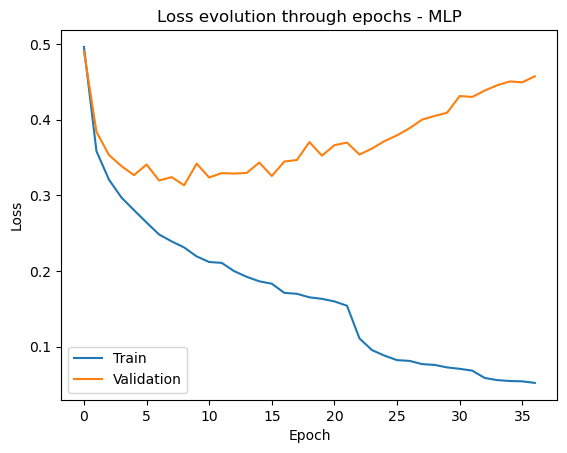

In [219]:
plt.plot(mlp_history.history["loss"], label="Train")
plt.plot(mlp_history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution through epochs - MLP')
plt.show()

Observamos en el loss el overfitting de la red neuronal a medida que aumentamos el entrenamiento.

##### Accuracy

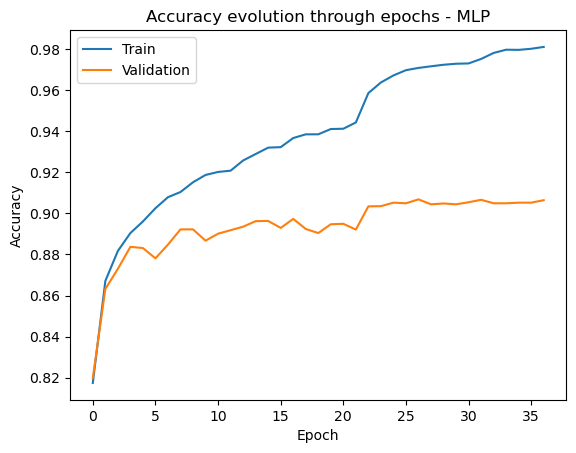

In [220]:
plt.plot(mlp_history.history["accuracy"], label="Train")
plt.plot(mlp_history.history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy evolution through epochs - MLP')
plt.show()

##### Precision

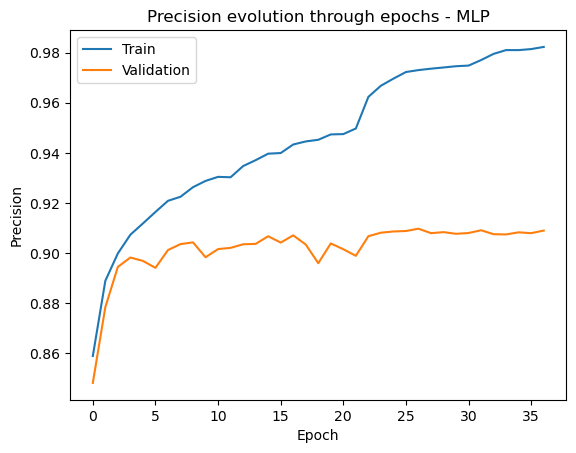

In [221]:
plt.plot(mlp_history.history["precision"], label="Train")
plt.plot(mlp_history.history["val_precision"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision evolution through epochs - MLP')
plt.show()

##### Recall

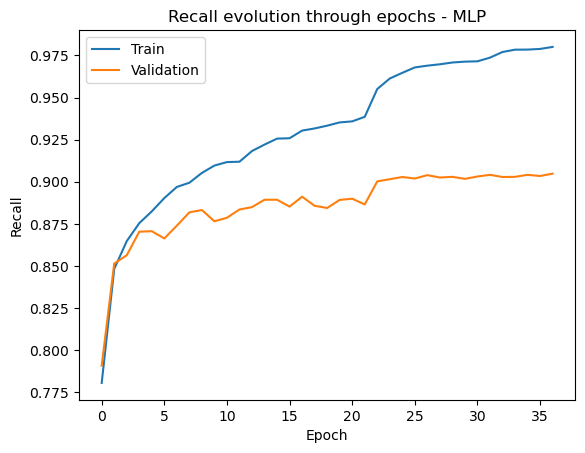

In [222]:
plt.plot(mlp_history.history["recall"], label="Train")
plt.plot(mlp_history.history["val_recall"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall evolution through epochs - MLP')
plt.show()

##### F1-Score

###### Macro

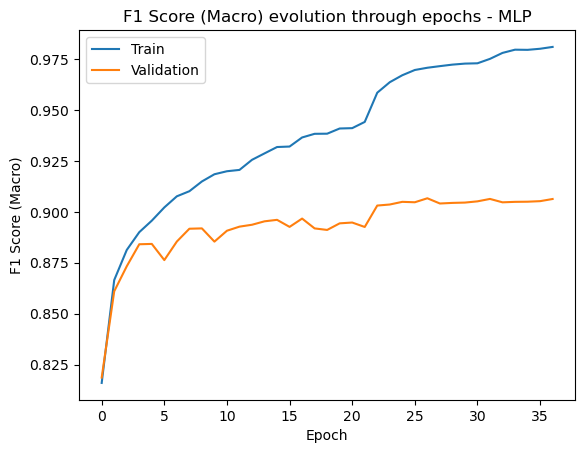

In [223]:
plt.plot(mlp_history.history["f1_score"], label="Train")
plt.plot(mlp_history.history["val_f1_score"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score (Macro) evolution through epochs - MLP')
plt.show()

###### Micro

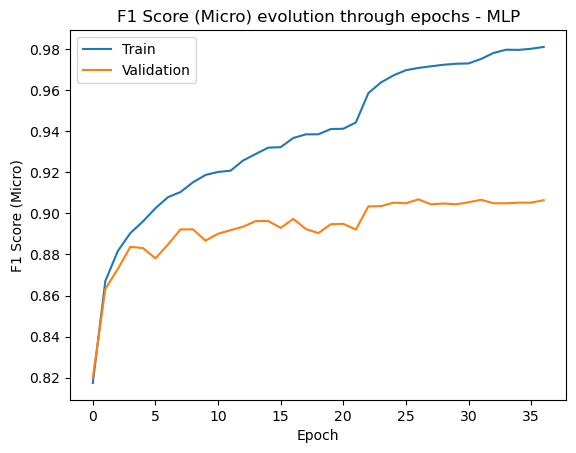

In [224]:
plt.plot(mlp_history.history["f1_score_micro"], label="Train")
plt.plot(mlp_history.history["val_f1_score_micro"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Micro)')
plt.title('F1 Score (Micro) evolution through epochs - MLP')
plt.show()

En este problema los F1 Score tanto macro como micro son muy similares a causa de que no existe desbalance de clases.

##### ROC and AUC

313/313 [==============================] - 0s 826us/step


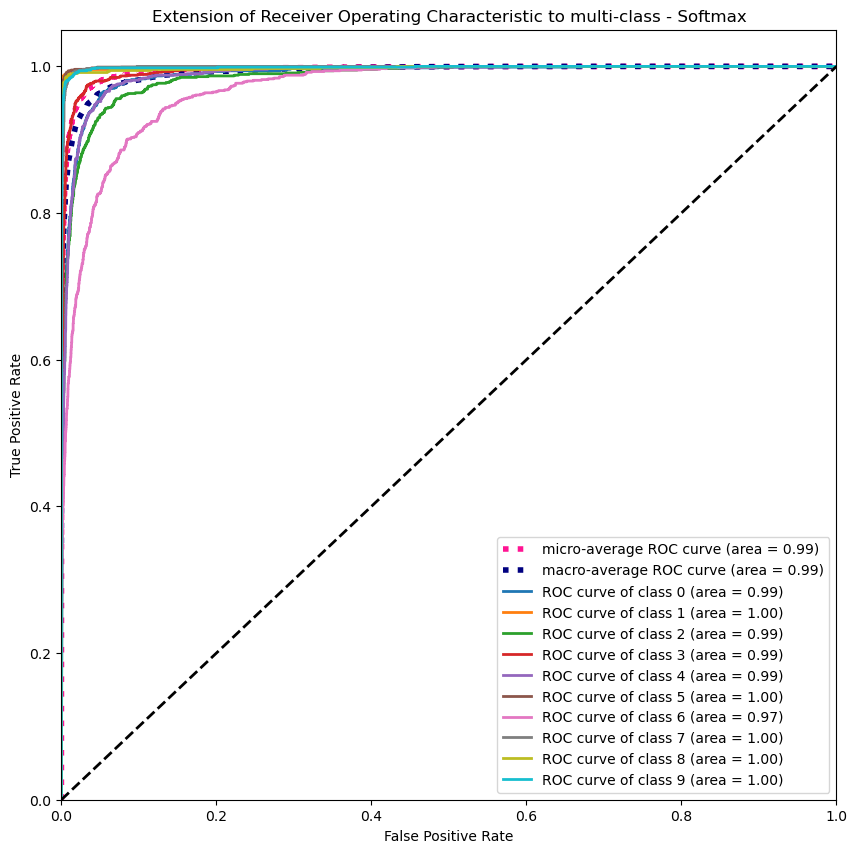

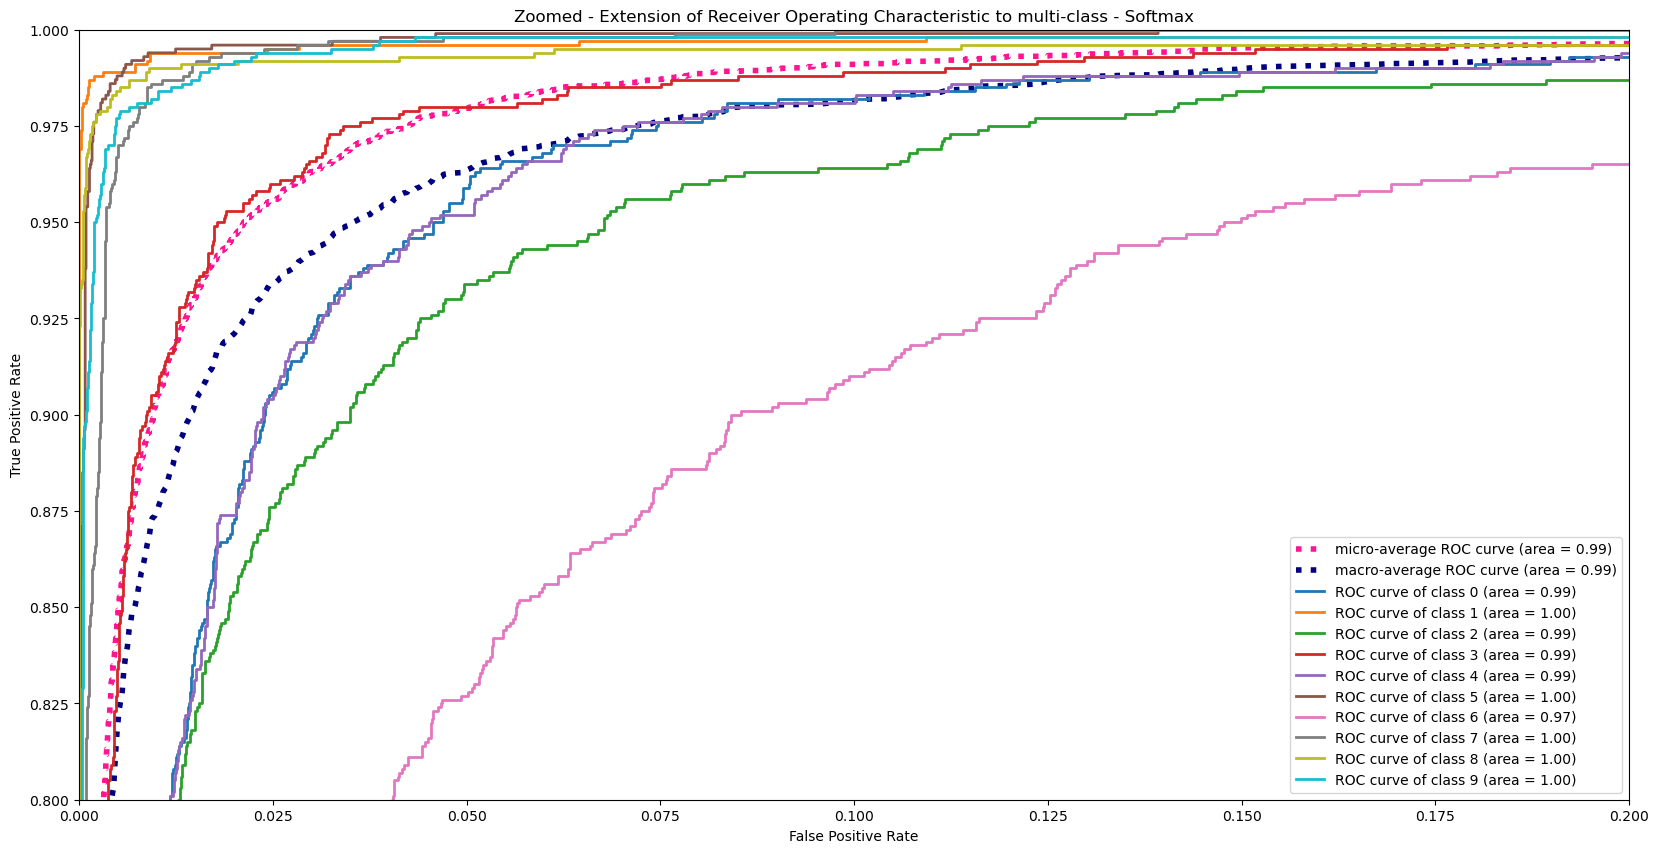

In [225]:
# Plot linewidth.
lw = 2

# Get score
y_score = mlp_model.predict(test_X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y_cat.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(20,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed - Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()

Al igual que para el F1 Score, las curvas ROC tanto macro como micro dan muy similares porque no hay desbalance de clases.

#### Kaggle competition

In [226]:
# We load the previously best weights
if (exists(checkpoint_filepath_mlp)):
   mlp_model.load_weights(checkpoint_filepath_mlp)

In [227]:
test_images = np.load("test_images.npy")
test_images = test_images / np.max(test_images)

In [228]:
test_predictions = np.argmax(mlp_model.predict(test_images), axis=-1)
print(test_predictions[1000:1005])
print(test_y[1000:1005])

313/313 [==============================] - 0s 835us/step
[3 9 9 5 0]
[0 3 5 5 6]


In [229]:
submission = pd.DataFrame({'id': np.arange(len(test_predictions)), 'Category': test_predictions})
submission.to_csv('submission.csv', index=False)

### Accuracy and iterations vs hyperparameters:

Para el modelo elegído, graficamos su accuracy y la cantidad de iteraciones de entrenamiento requeridas variando algunos hiperparametros

#### Define useful functions

In [230]:
# Callback to stop training if, after 10 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [231]:
# Callback to save logs and metrics for TensorBoard
log_dir_mlp = "logs/fit/mlp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_mlp = tf.keras.callbacks.TensorBoard(log_dir=log_dir_mlp)

In [232]:
# Callback to reduce LR if we find a plateau in validation accuracy
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=3, min_lr=0.00005)

In [233]:
callbacks = [early_stop_callback, tensorboard_callback_mlp, reduce_lr]

#### Vs Learning Rate

In [234]:
mlp_model = Sequential()
mlp_model.add(layers.Flatten(input_shape=(28,28)))
mlp_model.add(layers.BatchNormalization())
mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dropout(0.10))
mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dropout(0.05))
mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dense(num_classes, activation="softmax"))
mlp_model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_37 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_33 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_141 (Dense)           (None, 512)               401920    
                                                                 
 dropout_68 (Dropout)        (None, 512)               0         
                                                                 
 dense_142 (Dense)           (None, 64)                32832     
                                                                 
 dropout_69 (Dropout)        (None, 64)                0         
                                                     

In [235]:
train_accuracy = []
val_accuracy = []
num_of_steps = []
learning_rate = []

for i in range(10):
    # Model initialization
    mlp_model = Sequential()
    mlp_model.add(layers.Flatten(input_shape=(28,28)))
    mlp_model.add(layers.BatchNormalization())
    mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dropout(0.10))
    mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dropout(0.05))
    mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dense(num_classes, activation="softmax"))
    mlp_model.summary()

    # Model compilation and training
    optimizer = optimizers.Nadam(learning_rate= i * 0.001 + 0.001, beta_1=0.94, beta_2=0.999)
    learning_rate.append(i * 0.001 + 0.001)
    metrics = ["accuracy"]
    mlp_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=100, callbacks=[early_stop_callback, tensorboard_callback_mlp]) # We remove the reduce_lr callback as we are checking variations with LR
    train_accuracy.append(np.max(mlp_history.history["accuracy"]))
    val_accuracy.append(np.max(mlp_history.history["val_accuracy"]))
    num_of_steps.append(len(mlp_history.history["accuracy"]) * 64) # Iterations = num of epochs * batch size
 

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_38 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_34 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_145 (Dense)           (None, 512)               401920    
                                                                 
 dropout_70 (Dropout)        (None, 512)               0         
                                                                 
 dense_146 (Dense)           (None, 64)                32832     
                                                                 
 dropout_71 (Dropout)        (None, 64)                0         
                                                     

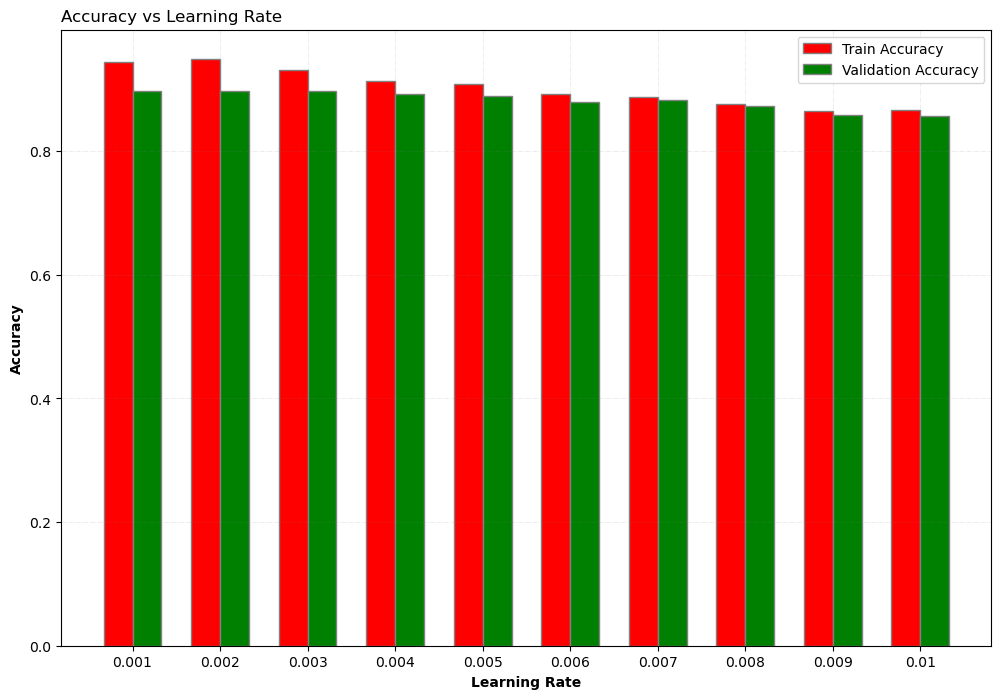

In [236]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(learning_rate))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_accuracy, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Accuracy')
plt.bar(br2, val_accuracy, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Accuracy')
 
plt.xlabel('Learning Rate', fontweight ='bold', fontsize = 10)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(learning_rate))],
        ['0.001', '0.002', '0.003', '0.004', '0.005', '0.006', '0.007', '0.008', '0.009', '0.01'])
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Accuracy vs Learning Rate',
             loc ='left', )
plt.legend()
plt.show()

Observamos como, a medida que aumenta el learning rate, disminuye la accuracy tanto de entrenamiento como de validación. Esto es porque un mayor learning rate le otorga mayor velocidad de convergencia, pero menor precisión para obtener el minimo del loss, que genera menores valores de accuracy.

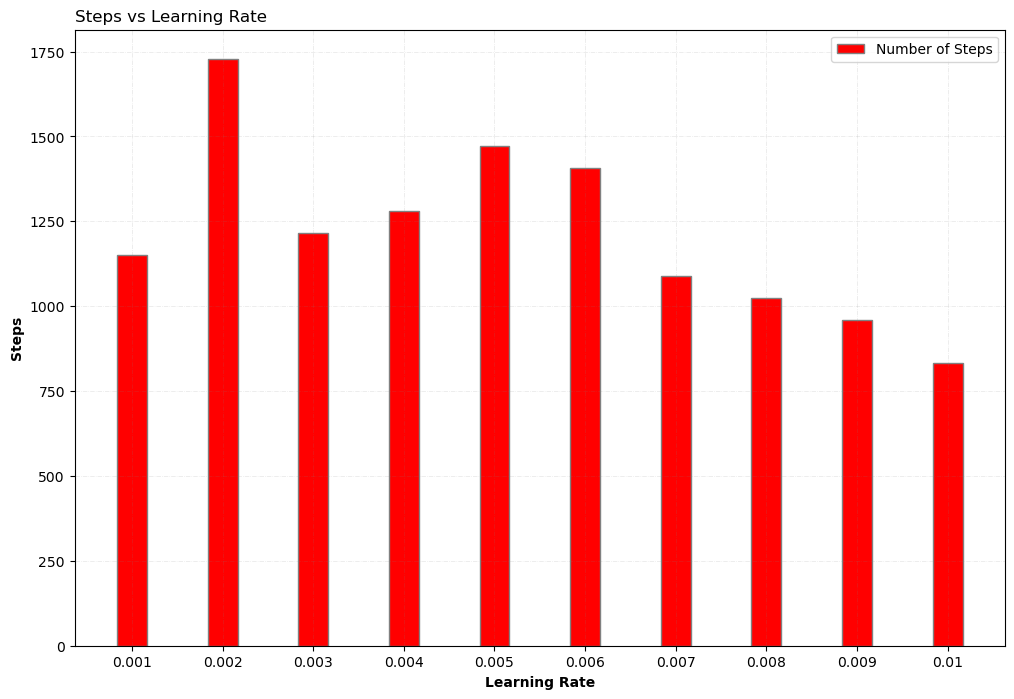

In [237]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(learning_rate))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Learning Rate', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(learning_rate))],
        ['0.001', '0.002', '0.003', '0.004', '0.005', '0.006', '0.007', '0.008', '0.009', '0.01'])
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Learning Rate',
             loc ='left', )
plt.legend()
plt.show()

Como utilizamos un callback de early stop, tiene sentido que en promedio la cantidad de steps baje a medida que aumentamos el learning rate, ya que converge más rápido al mínimo local y por el early stop frena el entrenamiento antes. Vemos sin embargo una anomalía en algunos casos como $LR = 0.001$ y $LR = 0.003$, que se puede haber dado a causa de que el early stop se haya activado antes de lo esperado.

#### Vs Batch Size

In [238]:
train_accuracy = []
val_accuracy = []
num_of_steps = []
batch_size = []

for i in range(5):
    # Model initialization
    mlp_model = Sequential()
    mlp_model.add(layers.Flatten(input_shape=(28,28)))
    mlp_model.add(layers.BatchNormalization())
    mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dropout(0.10))
    mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dropout(0.05))
    mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dense(num_classes, activation="softmax"))
    mlp_model.summary()

    # Model compiling and training
    optimizer = optimizers.Nadam(learning_rate=0.002, beta_1=0.94, beta_2=0.999)
    curr_batch_size = 32 * 2 ** i
    batch_size.append(curr_batch_size)
    metrics = ["accuracy"]
    mlp_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = curr_batch_size, epochs=100, callbacks=callbacks)
    train_accuracy.append(np.max(mlp_history.history["accuracy"]))
    val_accuracy.append(np.max(mlp_history.history["val_accuracy"]))
    num_of_steps.append(len(mlp_history.history["accuracy"]) * curr_batch_size) # Iterations = num of epochs * batch size
 

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_48 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_44 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_185 (Dense)           (None, 512)               401920    
                                                                 
 dropout_90 (Dropout)        (None, 512)               0         
                                                                 
 dense_186 (Dense)           (None, 64)                32832     
                                                                 
 dropout_91 (Dropout)        (None, 64)                0         
                                                     

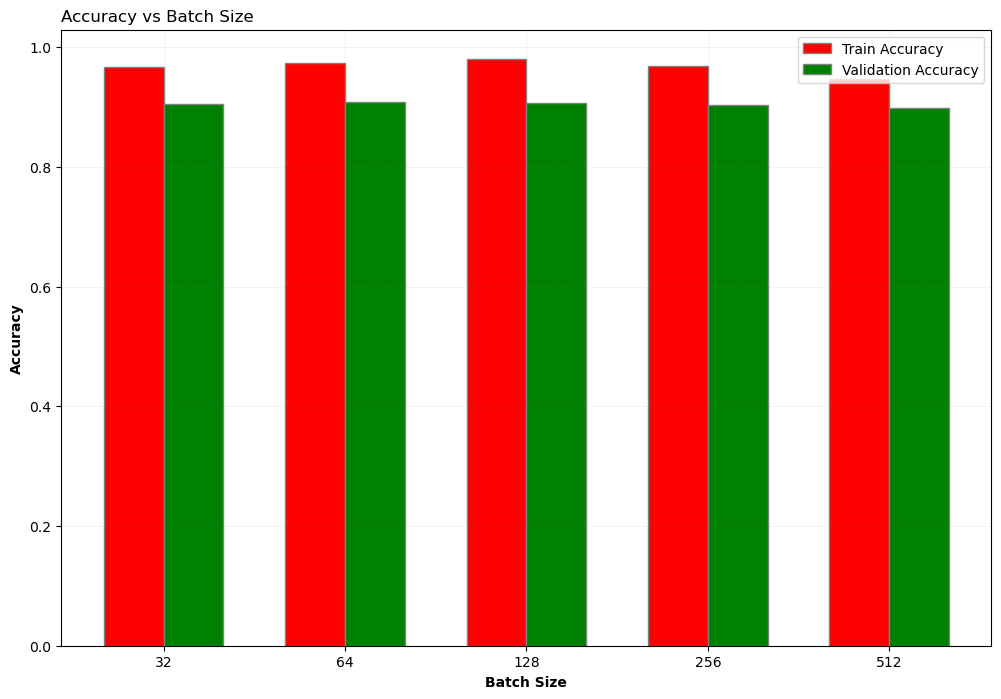

In [239]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(batch_size))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_accuracy, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Accuracy')
plt.bar(br2, val_accuracy, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Accuracy')
 
plt.xlabel('Batch Size', fontweight ='bold', fontsize = 10)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(batch_size))],
        ['32', '64', '128', '256', '512'])
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Accuracy vs Batch Size',
             loc ='left', )
plt.legend()
plt.show()

Observamos que, mientras que el accuracy de validacion se mantiene prácticamente igual, el accuracy de training tiene un máximo en Batch size $= 128$. Tiene sentido que este sea mayor a los de batch size menores, ya que se entrenó más veces con los datos de training, pero es dificil de explicar el motivo por el cual es mayor que el accuracy de batch size mayores, ya que se supone que estos deberían tener mejor rendimiento en el dataset de training, y peor rendimiento en el de validación, a causa de tener más error al generalizarse (mayor overfitting).

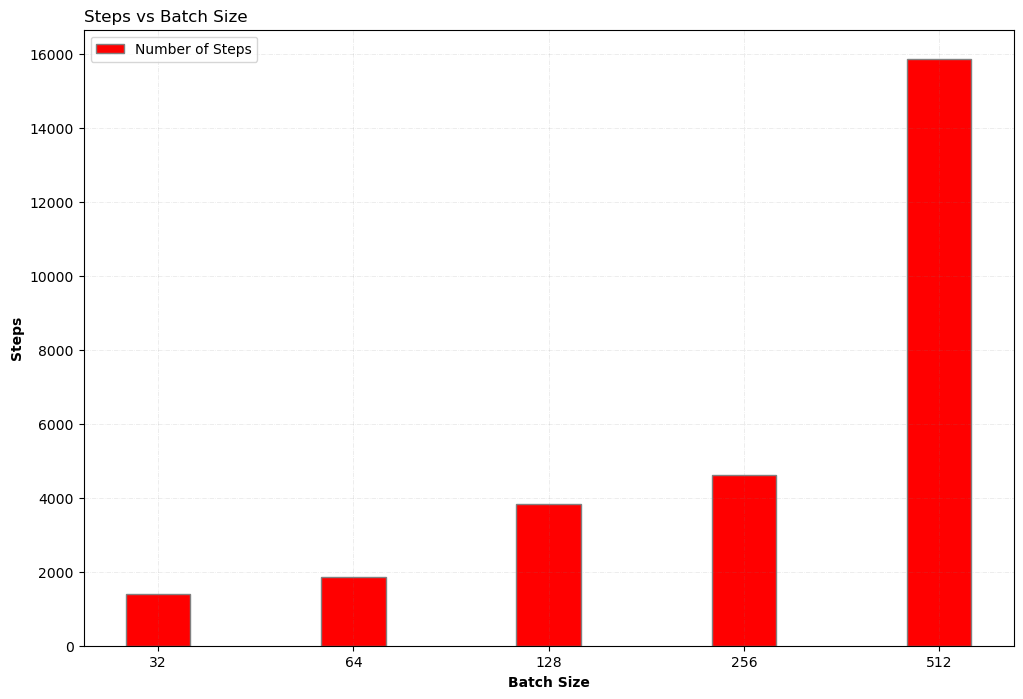

In [240]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(batch_size))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Batch Size', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(batch_size))],
        ['32', '64', '128', '256', '512'])
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Batch Size',
             loc ='left', )
plt.legend()
plt.show()

Observamos, como se esperaba, que los steps realizadas aumentan junto con el batch size, ya que en cada iteración se pasan una mayor cantidad de datos por el modelo.

#### Vs Optimizadores

In [241]:
train_accuracy = []
val_accuracy = []
num_of_steps = []
optimizers_list = []

for i in range(3):
    # Model initialization
    mlp_model = Sequential()
    mlp_model.add(layers.Flatten(input_shape=(28,28)))
    mlp_model.add(layers.BatchNormalization())
    mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dropout(0.10))
    mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dropout(0.05))
    mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dense(num_classes, activation="softmax"))
    mlp_model.summary()

    # Model compiling and training
    if (i == 0):
        optimizer = optimizers.Nadam(learning_rate=0.002, beta_1=0.94, beta_2=0.999)
        optimizers_list.append("nadam")
    elif (i == 1):
        optimizer = optimizers.Adam(learning_rate=0.002, beta_1=0.94, beta_2=0.999)
        optimizers_list.append("adam")
    elif (i == 2):
        optimizer = optimizers.SGD(learning_rate=0.01)
        optimizers_list.append("SGD")
    metrics = ["accuracy"]
    mlp_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=100, callbacks=callbacks)
    train_accuracy.append(np.max(mlp_history.history["accuracy"]))
    val_accuracy.append(np.max(mlp_history.history["val_accuracy"]))
    num_of_steps.append(len(mlp_history.history["accuracy"]) * 64) # Iterations = num of epochs * batch size
 

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_53 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_49 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_205 (Dense)           (None, 512)               401920    
                                                                 
 dropout_100 (Dropout)       (None, 512)               0         
                                                                 
 dense_206 (Dense)           (None, 64)                32832     
                                                                 
 dropout_101 (Dropout)       (None, 64)                0         
                                                     

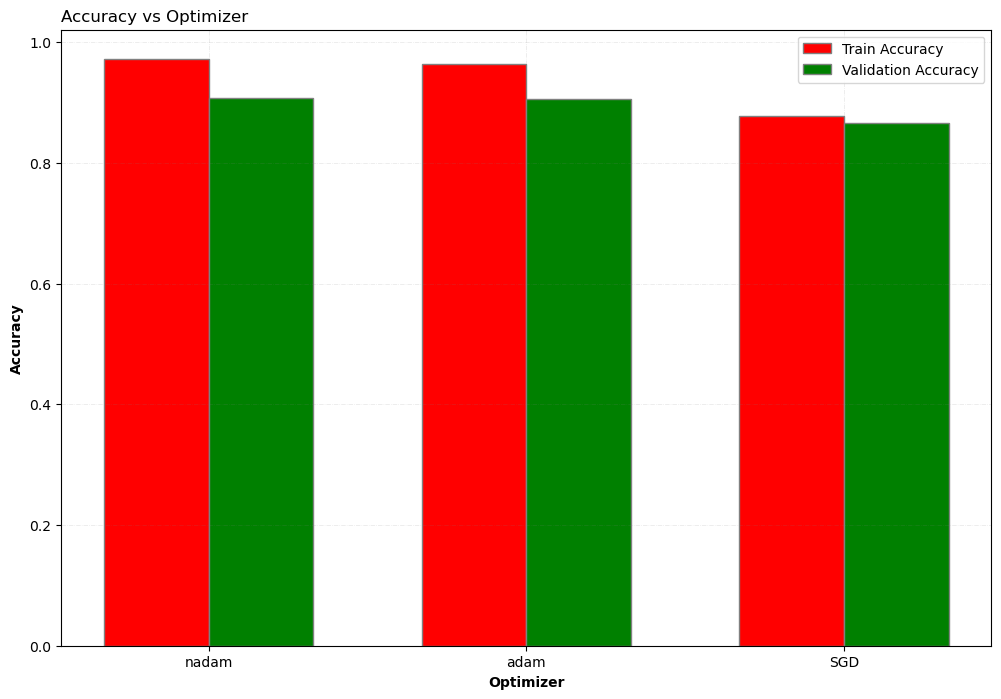

In [242]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(optimizers_list))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_accuracy, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Accuracy')
plt.bar(br2, val_accuracy, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Accuracy')
 
plt.xlabel('Optimizer', fontweight ='bold', fontsize = 10)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(optimizers_list))],
        optimizers_list)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Accuracy vs Optimizer',
             loc ='left', )
plt.legend()
plt.show()

Observamos que el de mayor performance tanto en training como en validación es Nadam, que es lo mismo que observamos durante el tuning de hiperparametros. Con respecto a SGD, esto ocurre porque tanto Nadam como Adam utilizan momentos y RMSProp para converger más velozmente al mínimo, mientras que SGD, incluso teniendo un learning rate considerablemente mayor, al no tener esta capacidad adaptativa falla en llegar al mínimo. Con respecto a Adam, suponemos que la mejora de rendimiento se da a causa de que Nadam utiliza momentos de Nesterov en lugar de momentos clásicos, y en este problema parecería ser que esto le brinda un beneficio a causa de la estructura y forma de los datos.

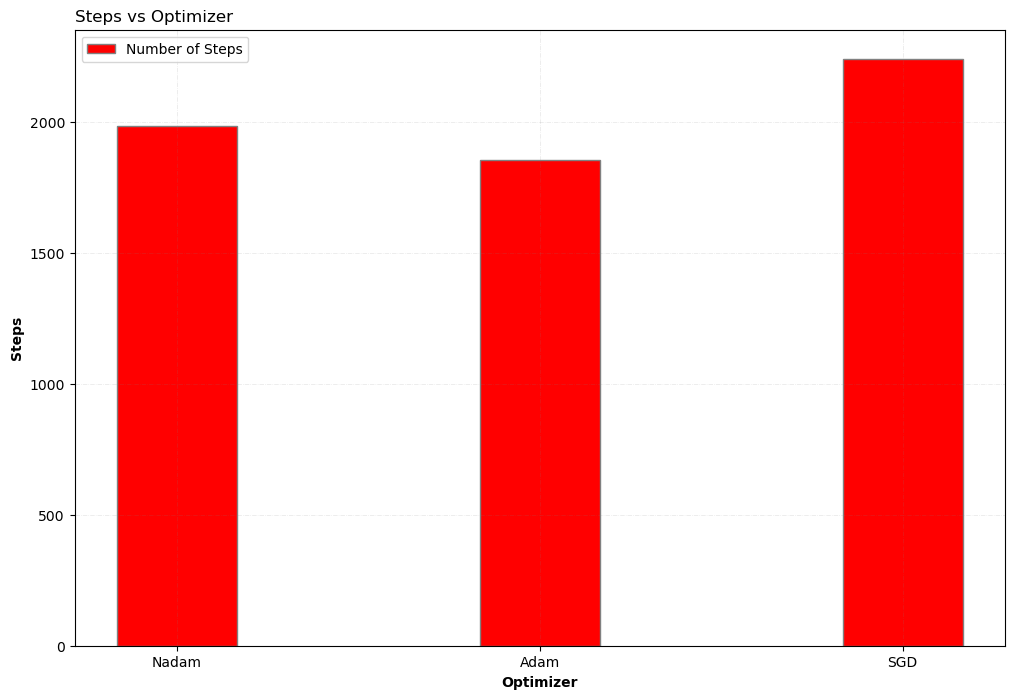

In [243]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(optimizers_list))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Optimizer', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(optimizers_list))],
        ['Nadam', 'Adam', 'SGD'])
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Optimizer',
             loc ='left', )
plt.legend()
plt.show()

Nuevamente, como se mencionó antes, SGD toma más pasos de entrenamiento a causa de carecer de momentos, mientras que la diferencia entre Nadam y Adam seguramente se deba a que el primero logró escapar del early stop más tiempo gracias a mejorar su accuracy a causa de los momentos de Nesterov.

#### Vs Activaciones

In [244]:
train_accuracy = []
val_accuracy = []
num_of_steps = []
acivation_list = []

for i in range(6):
    
    # Model initialization
    mlp_model = Sequential()
    mlp_model.add(layers.Flatten(input_shape=(28,28)))
    mlp_model.add(layers.BatchNormalization())

    if (i == 0):
        mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.10))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        acivation_list.append("elu")
    elif (i == 1):
        mlp_model.add(layers.Dense(512, activation="relu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.10))
        mlp_model.add(layers.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        acivation_list.append("relu")
    elif (i == 2):
        mlp_model.add(layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.10))
        mlp_model.add(layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        acivation_list.append("sigmoid")
    elif (i == 3):
        mlp_model.add(layers.Dense(512, activation="softmax", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.10))
        mlp_model.add(layers.Dense(64, activation="softmax", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="softmax", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        acivation_list.append("softmax")
    elif (i == 4):
        mlp_model.add(layers.Dense(512, activation="softplus", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.10))
        mlp_model.add(layers.Dense(64, activation="softplus", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="softplus", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        acivation_list.append("softplus")
    elif (i == 5):
        mlp_model.add(layers.Dense(512, activation="tanh", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.10))
        mlp_model.add(layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        acivation_list.append("tanh")
    
    mlp_model.add(layers.Dense(num_classes, activation="softmax"))
    mlp_model.summary()

    # Model compiling and training
    optimizer = optimizers.Nadam(learning_rate=0.002, beta_1=0.94, beta_2=0.999)
    metrics = ["accuracy"]
    mlp_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=100, callbacks=callbacks)
    train_accuracy.append(np.max(mlp_history.history["accuracy"]))
    val_accuracy.append(np.max(mlp_history.history["val_accuracy"]))
    num_of_steps.append(len(mlp_history.history["accuracy"]) * 64) # Iterations = num of epochs * batch size
 

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_56 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_52 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_217 (Dense)           (None, 512)               401920    
                                                                 
 dropout_106 (Dropout)       (None, 512)               0         
                                                                 
 dense_218 (Dense)           (None, 64)                32832     
                                                                 
 dropout_107 (Dropout)       (None, 64)                0         
                                                     

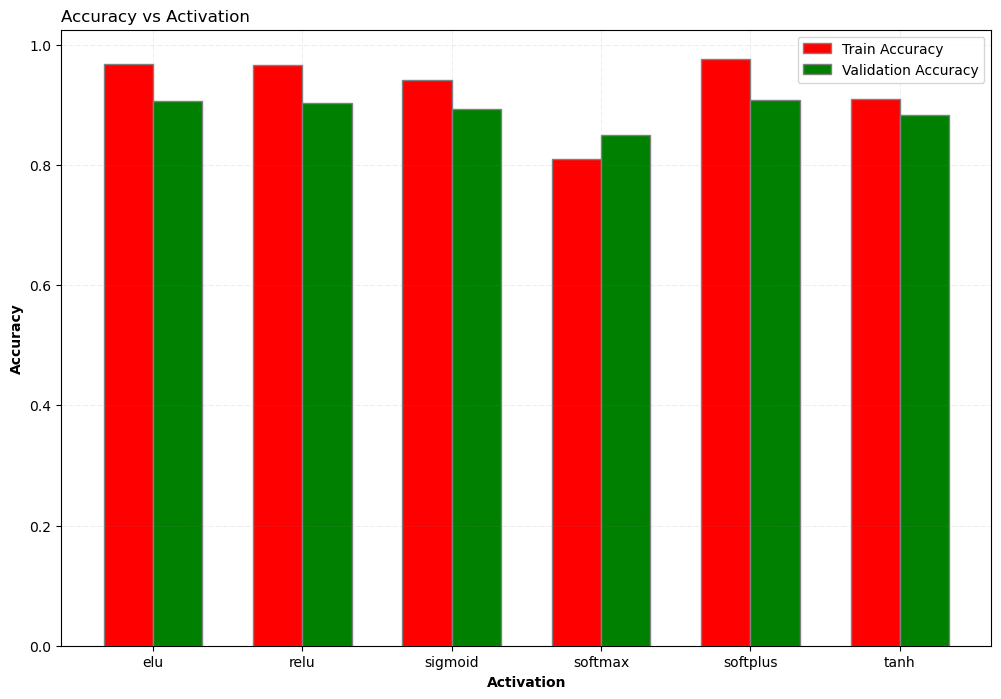

In [245]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(acivation_list))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_accuracy, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Accuracy')
plt.bar(br2, val_accuracy, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Accuracy')
 
plt.xlabel('Activation', fontweight ='bold', fontsize = 10)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(acivation_list))],
        acivation_list)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Accuracy vs Activation',
             loc ='left', )
plt.legend()
plt.show()

Observamos que el mejor activador para las capas es elu, seguido muy cerca del activador softplus.

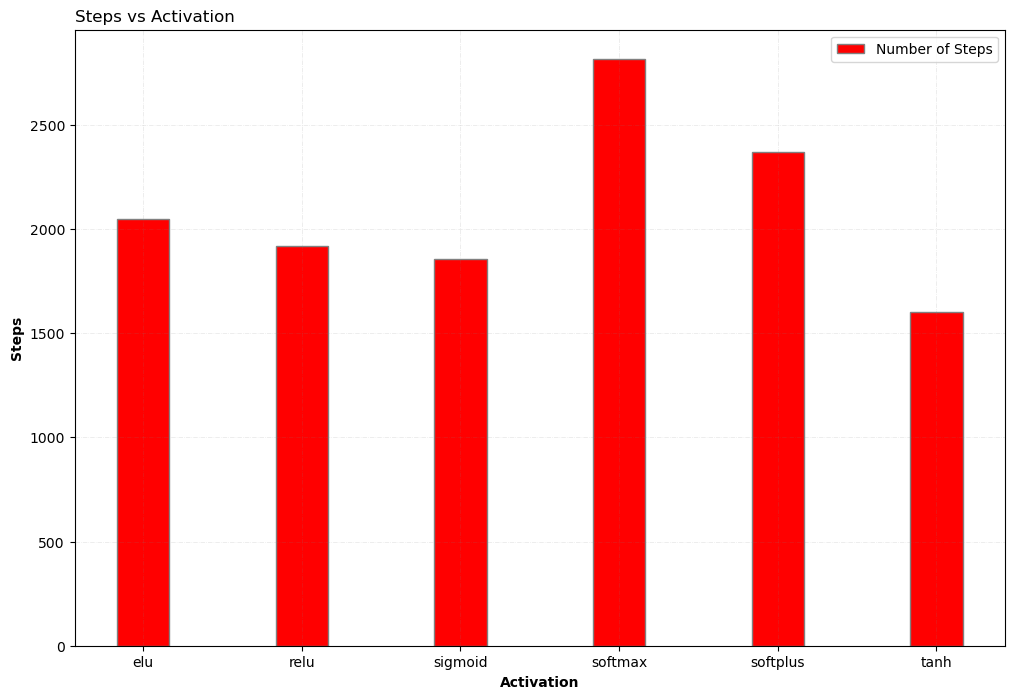

In [246]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(acivation_list))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Activation', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(acivation_list))],
        acivation_list)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Activation',
             loc ='left', )
plt.legend()
plt.show()

Vemos como elu consigue llegar a valores muy similares de accuracy que softplus con considerablemente menor entrenamiento requerido, por eso se eligió como activador.

#### Vs Dropout Rate

In [247]:
train_accuracy = []
val_accuracy = []
num_of_steps = []
dropout_list = []

for i in range(5):
    
    # Model initialization
    mlp_model = Sequential()
    mlp_model.add(layers.Flatten(input_shape=(28,28)))
    mlp_model.add(layers.BatchNormalization())

    if (i == 0):
        mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.0))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.0))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        dropout_list.append("No dropout")
    elif (i == 1):
        mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        dropout_list.append("5% dropout")
    elif (i == 2):
        mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.1))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.1))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        dropout_list.append("10% dropout")
    elif (i == 3):
        mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.2))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.2))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        dropout_list.append("20% dropout")
    elif (i == 4):
        mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.35))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.35))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        dropout_list.append("35% dropout")
    
    mlp_model.add(layers.Dense(num_classes, activation="softmax"))
    mlp_model.summary()

    # Model compiling and training
    optimizer = optimizers.Nadam(learning_rate=0.002, beta_1=0.94, beta_2=0.999)
    metrics = ["accuracy"]
    mlp_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=100, callbacks=callbacks)
    train_accuracy.append(np.max(mlp_history.history["accuracy"]))
    val_accuracy.append(np.max(mlp_history.history["val_accuracy"]))
    num_of_steps.append(len(mlp_history.history["accuracy"]) * 64) # Iterations = num of epochs * batch size
 

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_62 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_58 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_241 (Dense)           (None, 512)               401920    
                                                                 
 dropout_118 (Dropout)       (None, 512)               0         
                                                                 
 dense_242 (Dense)           (None, 64)                32832     
                                                                 
 dropout_119 (Dropout)       (None, 64)                0         
                                                     

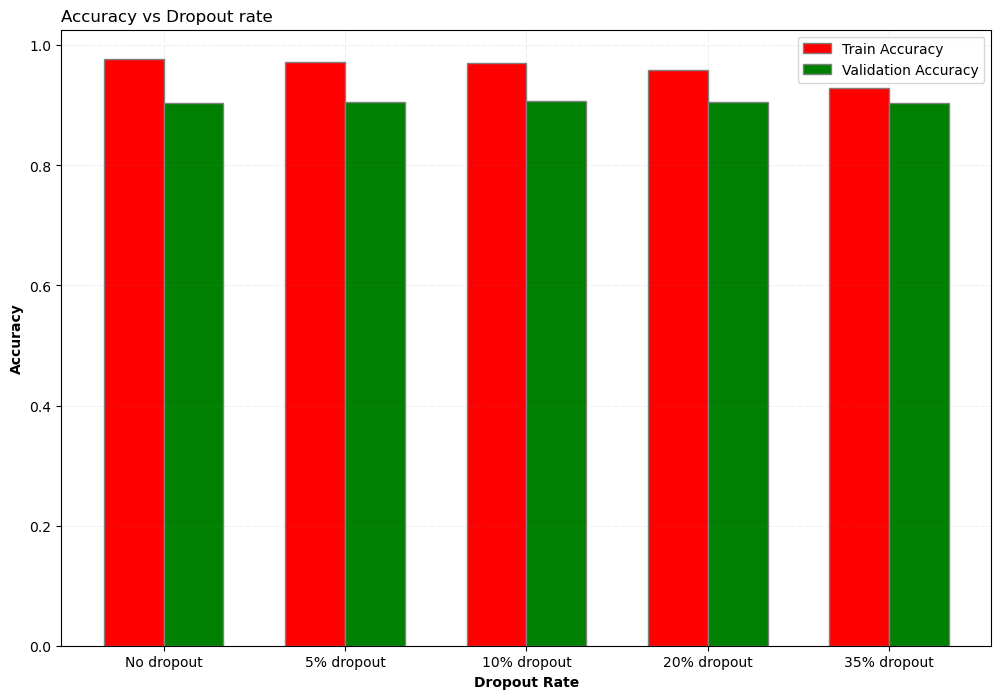

In [248]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(dropout_list))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_accuracy, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Accuracy')
plt.bar(br2, val_accuracy, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Accuracy')
 
plt.xlabel('Dropout Rate', fontweight ='bold', fontsize = 10)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(dropout_list))],
        dropout_list)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Accuracy vs Dropout rate',
             loc ='left', )
plt.legend()
plt.show()

Vemos como, al aumentar el dropout, disminuye la accuracy de training. Esto es lo esperado, ya que el dropout se utiliza para intentar evitar el overfitting (que traería mayor accuracy de training pero menor de validación).

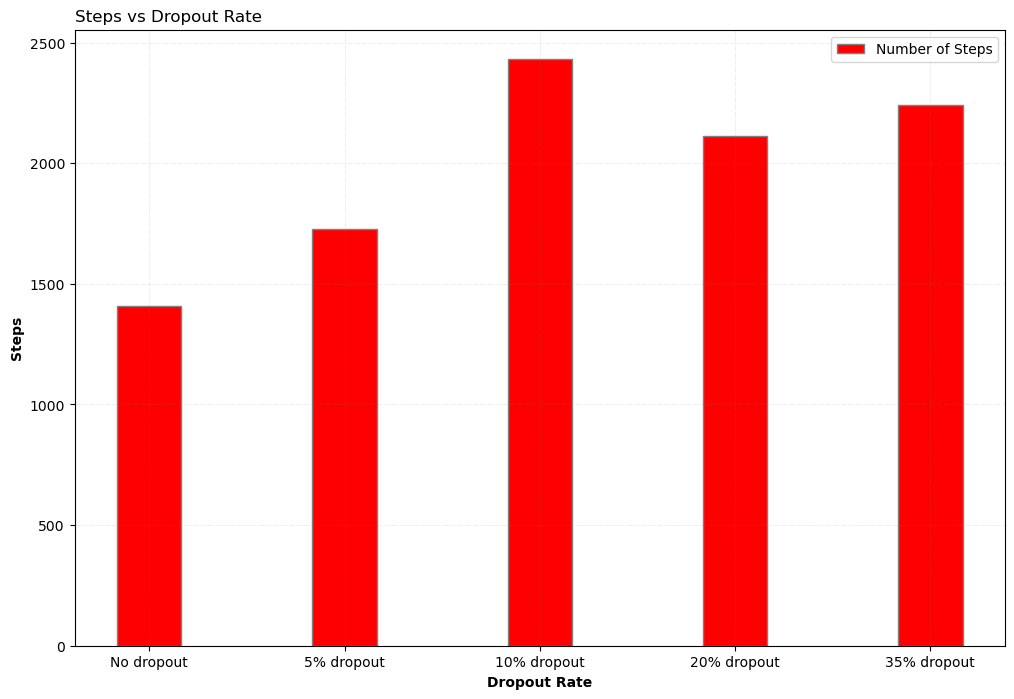

In [249]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(dropout_list))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Dropout Rate', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(dropout_list))],
        dropout_list)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Dropout Rate',
             loc ='left', )
plt.legend()
plt.show()

Observamos que a medida que aumentamos el dropout, aumenta la cantidad de steps de entrenamiento porque se lográ incrementar la accuracy de validación y evitar el early stop. Esto deja de ocurrir luego de un 10% de dropout, dandonos a entender que mayor dropout que ese para este problema termina siendo nocivo para el entrenamiento y disminuye la accuracy máxima alcanzada.

#### Vs Batch Normalization

In [250]:
train_accuracy = []
val_accuracy = []
num_of_steps = []
batch_normalization_status = []

for i in range(2):
    # Model initialization
    mlp_model = Sequential()
    mlp_model.add(layers.Flatten(input_shape=(28,28)))
    if(i == 0):
        mlp_model.add(layers.BatchNormalization())
        batch_normalization_status.append("B.N. ON")
    else:
        batch_normalization_status.append("B.N. OFF")
    mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dropout(0.10))
    mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dropout(0.05))
    mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
    mlp_model.add(layers.Dense(num_classes, activation="softmax"))
    mlp_model.summary()

    # Model compiling and training
    optimizer = optimizers.Nadam(learning_rate=0.002, beta_1=0.94, beta_2=0.999)
    metrics = ["accuracy"]
    mlp_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=100, callbacks=callbacks)
    train_accuracy.append(np.max(mlp_history.history["accuracy"]))
    val_accuracy.append(np.max(mlp_history.history["val_accuracy"]))
    num_of_steps.append(len(mlp_history.history["accuracy"]) * 64) # Iterations = num of epochs * batch size
 

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_67 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_63 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_261 (Dense)           (None, 512)               401920    
                                                                 
 dropout_128 (Dropout)       (None, 512)               0         
                                                                 
 dense_262 (Dense)           (None, 64)                32832     
                                                                 
 dropout_129 (Dropout)       (None, 64)                0         
                                                     

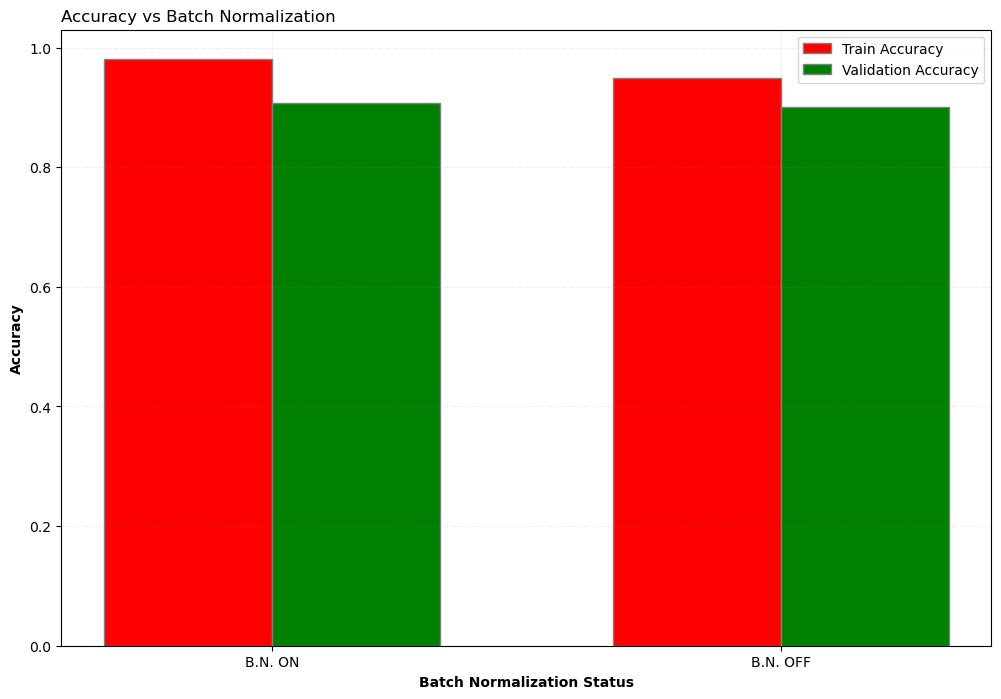

In [251]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(batch_normalization_status))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_accuracy, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Accuracy')
plt.bar(br2, val_accuracy, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Accuracy')
 
plt.xlabel('Batch Normalization Status', fontweight ='bold', fontsize = 10)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(batch_normalization_status))],
        batch_normalization_status)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Accuracy vs Batch Normalization',
             loc ='left', )
plt.legend()
plt.show()

Observamos como utilizar batch normalization con este modelo incrementa considerablemente tanto el accuracy de training como el de validación.

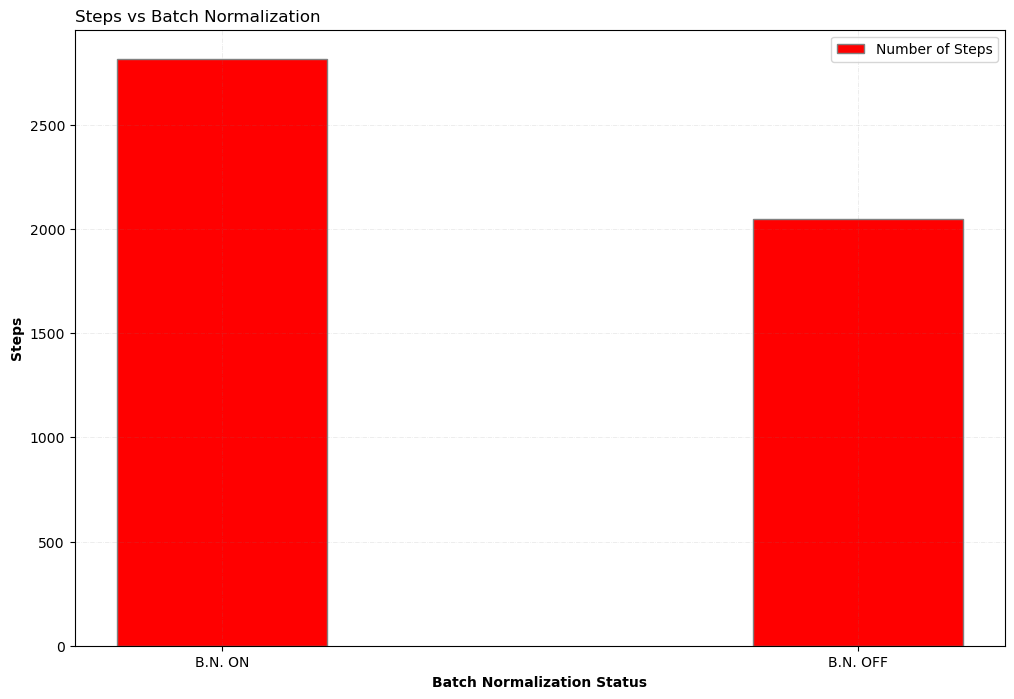

In [252]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(batch_normalization_status))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Batch Normalization Status', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(batch_normalization_status))],
        batch_normalization_status)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Batch Normalization',
             loc ='left', )
plt.legend()
plt.show()

Sin embargo, para incrementar el accuracy, requerimos de mayor tiempo de entrenamiento.

#### Vs Inicializaciones de Pesos

In [253]:
train_accuracy = []
val_accuracy = []
num_of_steps = []
weight_initializations = []

for i in range(4):
    
    # Model initialization
    mlp_model = Sequential()
    mlp_model.add(layers.Flatten(input_shape=(28,28)))
    mlp_model.add(layers.BatchNormalization())

    if (i == 0):
        mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.10))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        weight_initializations.append("random_normal_dev_1e-3")
    elif (i == 1):
        mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)))
        mlp_model.add(layers.Dropout(0.10))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)))
        weight_initializations.append("random_normal_dev_1e-1")
    elif (i == 2):
        mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.GlorotNormal()))
        mlp_model.add(layers.Dropout(0.10))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.GlorotNormal()))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.GlorotNormal()))
        weight_initializations.append("glorot_normal")
    elif (i == 3):
        mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
        mlp_model.add(layers.Dropout(0.10))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
        mlp_model.add(layers.Dropout(0.05))
        mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.GlorotUniform()))
        weight_initializations.append("glorot_uniform")
    
    mlp_model.add(layers.Dense(num_classes, activation="softmax"))
    mlp_model.summary()

    # Model compiling and training
    optimizer = optimizers.Nadam(learning_rate=0.002, beta_1=0.94, beta_2=0.999)
    metrics = ["accuracy"]
    mlp_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=100, callbacks=callbacks)
    train_accuracy.append(np.max(mlp_history.history["accuracy"]))
    val_accuracy.append(np.max(mlp_history.history["val_accuracy"]))
    num_of_steps.append(len(mlp_history.history["accuracy"]) * 64) # Iterations = num of epochs * batch size
 

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_69 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_64 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_269 (Dense)           (None, 512)               401920    
                                                                 
 dropout_132 (Dropout)       (None, 512)               0         
                                                                 
 dense_270 (Dense)           (None, 64)                32832     
                                                                 
 dropout_133 (Dropout)       (None, 64)                0         
                                                     

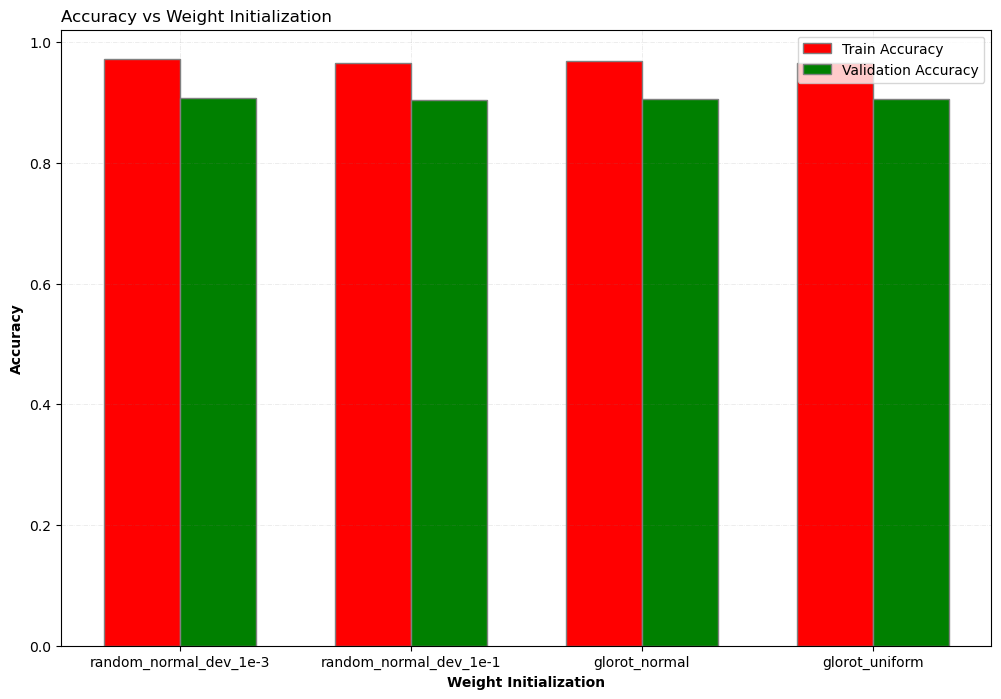

In [254]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(weight_initializations))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_accuracy, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Accuracy')
plt.bar(br2, val_accuracy, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Accuracy')
 
plt.xlabel('Weight Initialization', fontweight ='bold', fontsize = 10)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(weight_initializations))],
        weight_initializations)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Accuracy vs Weight Initialization',
             loc ='left', )
plt.legend()
plt.show()

Observamos como las distintas inicializaciones de los pesos se comportan de manera similar, más notablemente en el accuracy de validación. Sin embargo, la mayor performance se obtiene utilizando una inicialización RandomNormal con desviación de 0.001

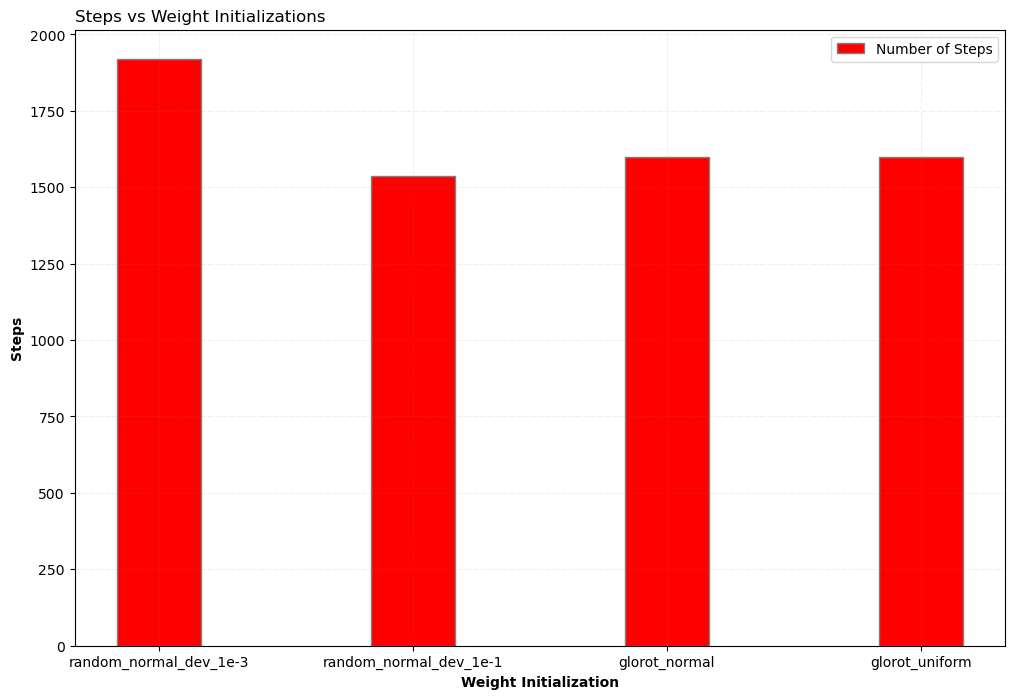

In [255]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(weight_initializations))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Weight Initialization', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(weight_initializations))],
        weight_initializations)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Weight Initializations',
             loc ='left', )
plt.legend()
plt.show()

Observamos que con la inicialización mencionada se requieren más pasos de entrenamiento, pero se llega a un mínimo más pequeño.

### 1.3 - Retraining con capa de tamaño 2 antes de la salida

#### Compile and train the model

In [256]:
# Callback to stop training if, after 10 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [257]:
# Callback to save the weights of the best model
checkpoint_filepath_mlp = './checkpoints/mlp/'
model_checkpoint_callback_mlp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_mlp,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [258]:
# Callback to save logs and metrics for TensorBoard
log_dir_mlp = "logs/fit/mlp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_mlp = tf.keras.callbacks.TensorBoard(log_dir=log_dir_mlp)

In [259]:
# Callback to reduce LR if we find a plateau in validation accuracy
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.00005)

In [260]:
callbacks = [early_stop_callback, tensorboard_callback_mlp, model_checkpoint_callback_mlp, reduce_lr]

In [261]:
mlp_model = Sequential()
mlp_model.add(layers.Flatten(input_shape=(28,28)))
mlp_model.add(layers.BatchNormalization())
mlp_model.add(layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dropout(0.10))
mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dropout(0.05))
mlp_model.add(layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
mlp_model.add(layers.Dense(2, activation="linear")) # New layer
mlp_model.add(layers.Dense(num_classes, activation="softmax"))
mlp_model.summary()

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_73 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_68 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_285 (Dense)           (None, 512)               401920    
                                                                 
 dropout_140 (Dropout)       (None, 512)               0         
                                                                 
 dense_286 (Dense)           (None, 64)                32832     
                                                                 
 dropout_141 (Dropout)       (None, 64)                0         
                                                     

In [262]:
optimizer = optimizers.Nadam(learning_rate=0.002, beta_1=0.94, beta_2=0.999)
metrics = ["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
mlp_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=metrics)

In [263]:
mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=100, callbacks=callbacks)

Epoch 1/100
938/938 [==============================] - 4s 3ms/step - loss: 0.7969 - accuracy: 0.7282 - f1_score: 0.7248 - f1_score_micro: 0.7282 - precision: 0.8950 - recall: 0.5979 - val_loss: 0.5829 - val_accuracy: 0.7877 - val_f1_score: 0.7882 - val_f1_score_micro: 0.7877 - val_precision: 0.8668 - val_recall: 0.7058 - lr: 0.0020
Epoch 2/100
938/938 [==============================] - 3s 3ms/step - loss: 0.5043 - accuracy: 0.8335 - f1_score: 0.8332 - f1_score_micro: 0.8335 - precision: 0.9105 - recall: 0.7340 - val_loss: 0.5047 - val_accuracy: 0.8428 - val_f1_score: 0.8426 - val_f1_score_micro: 0.8428 - val_precision: 0.9039 - val_recall: 0.7794 - lr: 0.0020
Epoch 3/100
938/938 [==============================] - 3s 3ms/step - loss: 0.4386 - accuracy: 0.8558 - f1_score: 0.8556 - f1_score_micro: 0.8558 - precision: 0.8989 - recall: 0.8147 - val_loss: 0.4399 - val_accuracy: 0.8618 - val_f1_score: 0.8622 - val_f1_score_micro: 0.8618 - val_precision: 0.9013 - val_recall: 0.8283 - lr: 0.002

#### Feature extraction and decision thresholds

[[  111.91378   -195.30925 ]
 [  153.90897    151.86845 ]
 [-1957.7875     484.05353 ]
 ...
 [  106.80744    -39.423252]
 [-1148.7358     360.04123 ]
 [  -65.54131    -47.295624]]
[ 111.91378 -195.30925]


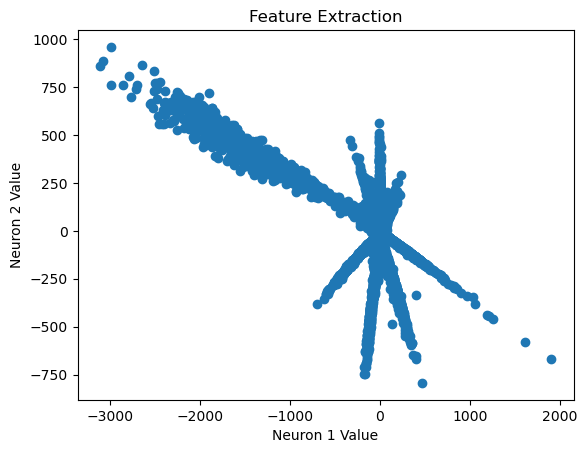

In [264]:
# Feature extraction testing

dual_layer = mlp_model.layers[-2]
dual_extractor = keras.Model(inputs=mlp_model.inputs,
                        outputs=dual_layer.output)
dual_features = dual_extractor(test_X)

softmax_layer = mlp_model.layers[-1]
softmax_extractor = keras.Model(inputs=softmax_layer.input,
                        outputs=mlp_model.output)
softmax_features = softmax_extractor(dual_features)

print(dual_features.numpy())
print(dual_features.numpy()[0])

plt.scatter(dual_features.numpy()[:,0], dual_features.numpy()[:,1])
plt.title("Feature Extraction")
plt.xlabel("Neuron 1 Value")
plt.ylabel("Neuron 2 Value")
plt.show()

1250/1250 [==============================] - 1s 561us/step


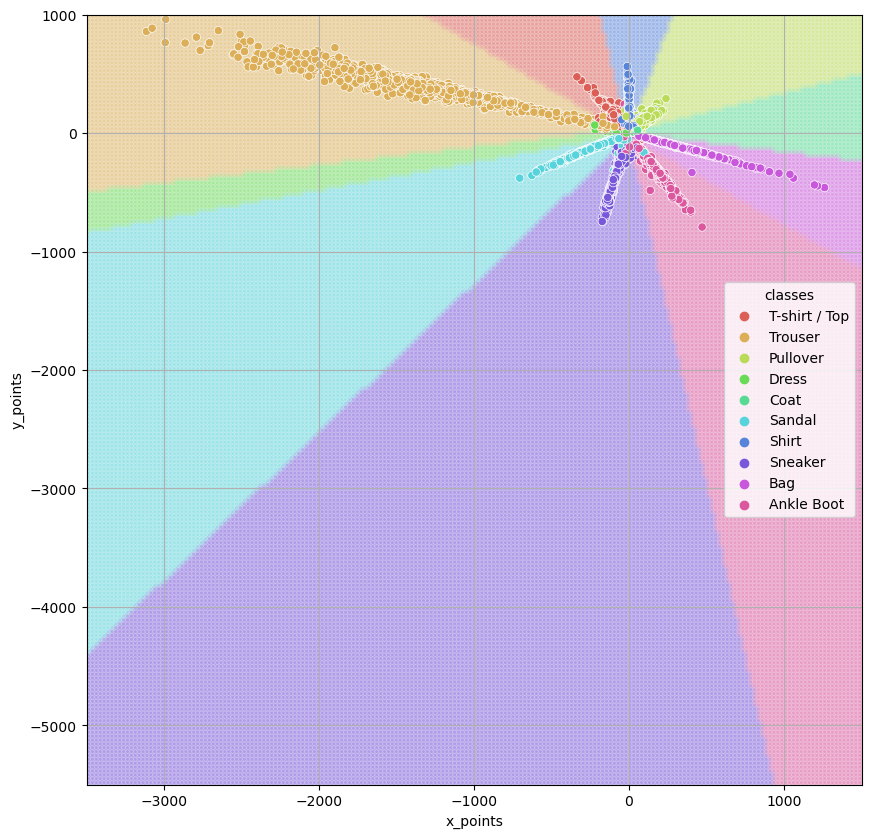

In [265]:
# Preparamos los labels para hacer la separación de clases en el gráfico
labels = {0: "T-shirt / Top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}
label_array = ["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Extraemos el output de la layer agregada de tamaño 2
dual_layer = mlp_model.layers[-2]
dual_extractor = keras.Model(inputs=mlp_model.inputs,
                        outputs=dual_layer.output)
dual_features = dual_extractor(test_X)

# Y extraemos la ultima capa del modelo para poder calcular sus outputs
softmax_layer = mlp_model.layers[-1]
softmax_extractor = keras.Model(inputs=softmax_layer.input,
                        outputs=mlp_model.output)

# Tenemos entonces los outputs de la layer agregada con la clase de cada uno
neuron_1_values = dual_features.numpy()[:,0]
neuron_2_values = dual_features.numpy()[:,1]
class_values = []
for i in range(len(test_y)):
    class_values.append(labels[test_y[i]])

# Creamos una grilla de puntos para analizar el output del modelo a los inputs provenientes de la layer de tamaño 2 (para los umbrales de decision)
grid_x = np.linspace(-3500, 1500, num=200)
grid_y = np.linspace(-5500, 1000, num=200)
grid_X, grid_Y = np.meshgrid(grid_x, grid_y)
inputs = np.column_stack((grid_X.flatten(), grid_Y.flatten())) # La convertimos en inputs para la ultima capa

# Obtenemos los resultados del modelo
prob_results = softmax_extractor.predict(inputs) # Predicciones probabilisticas, para asignarlas a una clase usamos argmax
results = []
for i in range(len(prob_results)):
    results.append(np.argmax(prob_results[i]).astype(int))

# Guardamos los resultados del modelo
x_points = inputs[:,0]
y_points = inputs[:,1]
class_values_model = []
for i in range(len(results)):
    class_values_model.append(labels[results[i]])

# Guardamos todo en dataframes de Pandas para poder graficarlo
l2_dataframe = pd.DataFrame()
l2_dataframe["neuron_1"] = neuron_1_values
l2_dataframe["neuron_2"] = neuron_2_values
l2_dataframe["classes"] = class_values

output_dataframe = pd.DataFrame()
output_dataframe["x_points"] = x_points
output_dataframe["y_points"] = y_points
output_dataframe["classes"] = class_values_model


# Graficamos ahora si los resultados
plt.figure(figsize=(10,10))
# Umbrales de decision
sns.scatterplot( x="x_points", y="y_points",
        hue = 'classes',
        hue_order = label_array,
        palette=sns.color_palette("hls", 10),
        data=output_dataframe,
        legend=None,
        alpha=0.2)
# Valores de test_X
sns.scatterplot( x="neuron_1", y="neuron_2",
        hue = 'classes',
        hue_order = label_array,
        palette=sns.color_palette("hls", 10),
        data=l2_dataframe,
        marker="o",    
        legend="auto",
        alpha=1)

plt.xlim(-3500,1500)
plt.ylim(-5500,1000)
plt.grid(True)